# Прогнозирование спроса
**Краткое описание**:
<br>Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства.
<br>Гранулярность ТК-SKU-День.

**Задача**:
<br>Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных признаков.

**Метрика качества - `WAPE`**:

```Python
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
```

**Описание данных**

- sales_df_train.csv –данные по продажам за скользящий год для обучения.
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата;
    - pr_sales_type_id – флаг наличия промо;
    - pr_sales_in_units – число проданных товаров всего (промо и без);
    - pr_promo_sales_in_units – число проданных товаров с признаком промо;
    - pr_sales_in_rub – продажи в РУБ всего (промо и без);
    - pr_promo_sales_in_rub – продажи с признаком промо в РУБ;
- pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
    - pr_group_id – захэшированная группа товара;
    - pr_cat_id – захэшированная категория товара;
    - pr_subcat_id – захэшированная подкатегория товара;
    - pr_sku_id – захэшированное id товара;
    - pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).
- pr_st.csv – данные по магазинам.
    - st_id – захэшированное id магазина;
    - st_city_id – захэшированное id города;
    - st_division_code id – захэшированное id дивизиона;
    - st_type_format_id – id формата магазина;
    - st_type_loc_id – id тип локации/окружения магазина;
    - st_type_size_id – id типа размера магазина;
    - st_is_active – флаг активного магазина на данный момент.
- sales_submission.csv – пример файла с результатом работы модели прогноза спроса.
<br>Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата (день);
    - target – спрос в ШТ.

## Setting up the work environment

In [36]:
# !pip install pandas
# !pip install seaborn
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install phik
# !pip install statsmodels
# !pip install scikit-learn
# !pip install category_encoders
# !pip install mlflow
# !pip install lightgbm
# !pip install optuna

!pip freeze > requirements.txt

In [1]:
import os
import math
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller
from phik.report import plot_correlation_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

# os.environ['VIRTUAL_ENV']

Объявление глобальных переменных

In [2]:
HOLIDAYS_PATH = 'data/holidays_covid_calendar.csv'
SALES_PATH = 'data/sales_df_train.csv'
PRODUCTS_PATH = 'data/pr_df.csv'
SHOPS_PATH = 'data/st_df.csv'

ASSETS_DIR = 'assets'
RANDOM_STATE = 42
DAYS_PRED = 14
random.seed(RANDOM_STATE)
EXPERIMENT_NAME = 'lenta_demand_forecast'

load_dotenv()
sns.set_style("white")
sns.set_theme(style="whitegrid")
pd.options.display.max_rows = 20
pd.options.display.max_columns = 30

connection = {"sslmode": "require",
              "target_session_attrs": "read-write"}
postgres_credentials = {"host": os.getenv("DB_HOST"),
                        "port": os.getenv("DB_PORT"),
                        "dbname": os.getenv("DB_NAME"),
                        "user": os.getenv("DB_USERNAME"),
                        "password": os.getenv("DB_PASSWORD")}
TRACKING_SERVER_PORT = os.getenv("TRACKING_SERVER_PORT")
TRACKING_SERVER_HOST = os.getenv("TRACKING_SERVER_HOST")

Импорт класса для проведения исследования

In [3]:
%load_ext autoreload
%autoreload 2

from regression_research_class import DatasetExplorer

## EDA

### sales_df_train

In [4]:
sales_explorer = DatasetExplorer(SALES_PATH)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB

Первые пять строк набора данных:


st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde60d8bf777ab6bc3b4   
3  42a0e188f5033bc65bf8d78622277c4e  8e887cf8e64ab8e7173701a979476567   
4  16a5cdae362b8d27a1d8f8c7b78b4330  e6fc24ca846339d204b0b50e9f772484   

         date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0  2022-10-20                 1                5.0                      5.0   
1  2023-01-29                 0                4.0                      0.0   
2  2023-03-02                 0                1.0                      0.0   
3  2023-04-05                 1                0.0                      0.0   
4  2023-02-17                 0                1.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub  
0            825.0                  825.0  
1            196.0                    0.0  
2             78.0                    0.0  
3             69.0                   69.0  
4            161.0                    0.0


Количество полных дубликатов строк:


0


Количество пропущенных значений:


st_id                      0
pr_sku_id                  0
date                       0
pr_sales_type_id           0
pr_sales_in_units          0
pr_promo_sales_in_units    0
pr_sales_in_rub            0
pr_promo_sales_in_rub      0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'st_id': 12
Соотношение уникальных значений и общего количества записей в столбце 'st_id': 0.0000
Количество уникальных значений в столбце 'pr_sku_id': 1991
Соотношение уникальных значений и общего количества записей в столбце 'pr_sku_id': 0.0023
Количество уникальных значений в столбце 'pr_sales_type_id': 2
Соотношение уникальных значений и общего количества записей в столбце 'pr_sales_type_id': 0.0000

Описательные статистики целевой переменной:


count    883015.000000
mean          5.037956
std          13.402984
min         -39.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

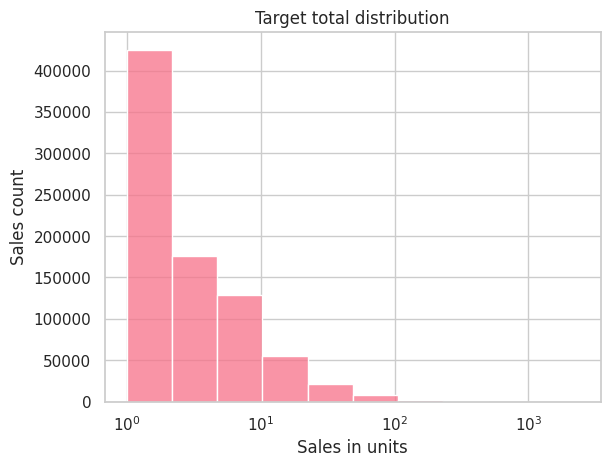

In [5]:
sales_df_train = sales_explorer.explore_dataset(target='pr_sales_in_units', assets_dir=None)

#### Выводы и наблюдения:
- для проведения дальнейшего исследования необходимо преобразование дат;
- пропусков в данных не обнаружено;
- полных дубликатов строк не обнаружено;
- количество уникальных товаров - 1991;
- в целевой переменной имеются отрицательные значения,
  <br>вероятно, это возвраты товаров.

### products_df

In [6]:
products_explorer = DatasetExplorer(PRODUCTS_PATH)

In [7]:
products_df = products_explorer.explore_dataset(target=None, assets_dir=None)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB

Первые пять строк набора данных:


pr_sku_id                       pr_group_id  \
0  fd064933250b0bfe4f926b867b0a5ec8  c74d97b01eae257e44aa9d5bade97baf   
1  71c9661741caf40a92a32d1cc8206c04  c74d97b01eae257e44aa9d5bade97baf   
2  00b72c2f01a1512cbb1d3f33319bac93  c74d97b01eae257e44aa9d5bade97baf   
3  9bc40cd2fe4f188f402bb41548c5e15c  c74d97b01eae257e44aa9d5bade97baf   
4  3a74a370c8eb032acb11ad9119242b8f  c74d97b01eae257e44aa9d5bade97baf   

                          pr_cat_id                      pr_subcat_id  \
0  1bc0249a6412ef49b07fe6f62e6dc8de  ca34f669ae367c87f0e75dcae0f61ee5   
1  c559da2ba967eb820766939a658022c8  e06f5ed77191826c212c30722f2cc5a2   
2  1bc0249a6412ef49b07fe6f62e6dc8de  d407a3ebb4ab9b0d68b224486f8b8dad   
3  1bc0249a6412ef49b07fe6f62e6dc8de  ca34f669ae367c87f0e75dcae0f61ee5   
4  c559da2ba967eb820766939a658022c8  e06f5ed77191826c212c30722f2cc5a2   

   pr_uom_id  
0         17  
1         17  
2         17  
3         17  
4         17


Количество полных дубликатов строк:


0


Количество пропущенных значений:


pr_sku_id       0
pr_group_id     0
pr_cat_id       0
pr_subcat_id    0
pr_uom_id       0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'pr_sku_id': 2050
Соотношение уникальных значений и общего количества записей в столбце 'pr_sku_id': 1.0000
Количество уникальных значений в столбце 'pr_group_id': 9
Соотношение уникальных значений и общего количества записей в столбце 'pr_group_id': 0.0044
Количество уникальных значений в столбце 'pr_cat_id': 43
Соотношение уникальных значений и общего количества записей в столбце 'pr_cat_id': 0.0210
Количество уникальных значений в столбце 'pr_subcat_id': 170
Соотношение уникальных значений и общего количества записей в столбце 'pr_subcat_id': 0.0829
Количество уникальных значений в столбце 'pr_uom_id': 2
Соотношение уникальных значений и общего количества записей в столбце 'pr_uom_id': 0.0010


#### Выводы и наблюдения:
- полных дубликатов строк не обнаружено;
- пропусков в данных не обнаружено.

### shops_df

In [8]:
shops_explorer = DatasetExplorer(SHOPS_PATH)

In [9]:
shops_df = shops_explorer.explore_dataset(target=None, assets_dir=None)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes

Первые пять строк набора данных:


st_id                        st_city_id  \
0  1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
1  bd470ca955d9497bbcb808e59952fffc  955d864a62659945cc9434898e275deb   
2  6364d3f0f495b6ab9dcf8d3b5c6e0b01  b8b4b727d6f5d1b61fff7be687f7970f   
3  1ecfb463472ec9115b10c292ef8bc986  908c9a564a86426585b29f5335b619bc   
4  16a5cdae362b8d27a1d8f8c7b78b4330  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                   st_division_code  st_type_format_id  st_type_loc_id  \
0  81b4dd343f5880df806d4c5d4a846c64                  4               3   
1  e26072c92d8fe0738df44d571d5f5e8b                  4               3   
2  da742b3cfca5388aaf9af28a726a3c30                  1               1   
3  429a86ff6336c144ddaf6144f52ab52c                  2               1   
4  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

   st_type_size_id  st_is_active  
0               19             0  
1               19             1  
2               12             1  
3               28             1  
4                8             1


Количество полных дубликатов строк:


0


Количество пропущенных значений:


st_id                0
st_city_id           0
st_division_code     0
st_type_format_id    0
st_type_loc_id       0
st_type_size_id      0
st_is_active         0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'st_id': 12
Соотношение уникальных значений и общего количества записей в столбце 'st_id': 1.0000
Количество уникальных значений в столбце 'st_city_id': 7
Соотношение уникальных значений и общего количества записей в столбце 'st_city_id': 0.5833
Количество уникальных значений в столбце 'st_type_format_id': 3
Соотношение уникальных значений и общего количества записей в столбце 'st_type_format_id': 0.2500
Количество уникальных значений в столбце 'st_type_loc_id': 3
Соотношение уникальных значений и общего количества записей в столбце 'st_type_loc_id': 0.2500
Количество уникальных значений в столбце 'st_type_size_id': 6
Соотношение уникальных значений и общего количества записей в столбце 'st_type_size_id': 0.5000


#### Выводы и наблюдения:
- полных дубликатов строк не обнаружено;
- пропущенных значений в данных не обнаружено;
- количество уникальных магазинов - 12

### holiday_df

In [10]:
holiday_explorer = DatasetExplorer(HOLIDAYS_PATH)

In [11]:
holiday_df = holiday_explorer.explore_dataset(target=None, assets_dir=None)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB

Первые пять строк набора данных:


year  day  weekday        date    calday  holiday  covid
0  2015    1        4  01.01.2015  20150101        1      0
1  2015    2        5  02.01.2015  20150102        1      0
2  2015    3        6  03.01.2015  20150103        1      0
3  2015    4        7  04.01.2015  20150104        1      0
4  2015    5        1  05.01.2015  20150105        1      0


Количество полных дубликатов строк:


0


Количество пропущенных значений:


year       0
day        0
weekday    0
date       0
calday     0
holiday    0
covid      0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'holiday': 2
Соотношение уникальных значений и общего количества записей в столбце 'holiday': 0.0005
Количество уникальных значений в столбце 'covid': 2
Соотношение уникальных значений и общего количества записей в столбце 'covid': 0.0005


#### Выводы и наблюдения:
- пропусков не обнаружено;
- повторов строк нет;
- в наборе данных имеются метка принадлежности выходного к covid-19;
- для дальнейшей работы с этим датафреймом необходимо преобразование дат.

### merge_df

In [12]:
holiday_df['date'] = pd.to_datetime(holiday_df['date'], format='%d.%m.%Y')
sales_df_train['date'] = pd.to_datetime(sales_df_train['date'], format='%Y-%m-%d')
main_df = (
    sales_df_train
    .merge(holiday_df[['date', 'holiday', 'covid']], on='date', how='left')
    .merge(shops_df, on='st_id', how='left')
    .merge(products_df, on='pr_sku_id', how='left')
)
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
 8   holiday                  883015 non-null  int64         
 9   covid                    883015 non-null  int64         
 10  st_city_id               883015 non-null  object        
 11  st_division_code         883015 non-null  object        
 12  st_type_format_i

In [13]:
print('Количество записей по активным и неактивным магазинам:')
main_df['st_is_active'].value_counts()

Количество записей по активным и неактивным магазинам:


st_is_active
1    882286
0       729
Name: count, dtype: int64

Вывод:
- количество записей по неактивным магазинам менее 1%,
  <br>принимаю решение данные записи удалить.

In [14]:
main_df = main_df[main_df['st_is_active'] == 1].reset_index(drop=True)

Количество отрицательных и нулевых значений целевой переменной:


66613

Доля отрицательных и нулевых значений целевой переменной в данных:


7.55

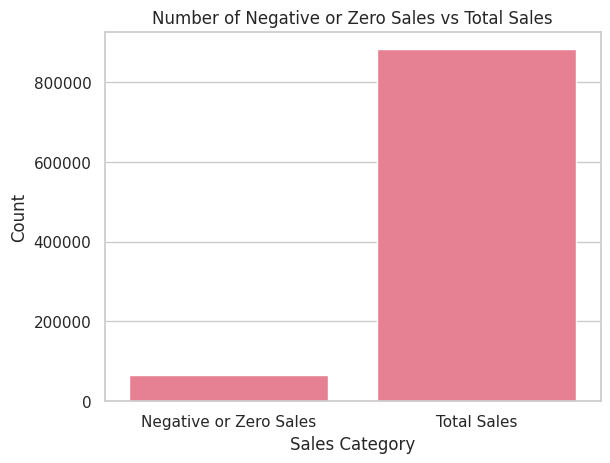

In [15]:
print('Количество отрицательных и нулевых значений целевой переменной:')
display(main_df[main_df['pr_sales_in_units'] <= 0]['st_id'].count())
print('Доля отрицательных и нулевых значений целевой переменной в данных:')
display(round((main_df[main_df['pr_sales_in_units'] <= 0]['st_id'].count() / main_df['st_id'].count()) * 100, 2))
print()
sales_categories = ['Negative or Zero Sales', 'Total Sales']
sales_counts = [main_df[main_df['pr_sales_in_units'] <= 0]['st_id'].count(), main_df['st_id'].count()]
sns.barplot(x=sales_categories, y=sales_counts)
plt.xlabel('Sales Category')
plt.ylabel('Count')
plt.title('Number of Negative or Zero Sales vs Total Sales')
plt.savefig(os.path.join(ASSETS_DIR, 'Number of Negative or Zero Sales vs Total Sales.png'))
plt.show()

Вывод:
- количество записей по с отрицательными и нулевыми значениями целевой переменной составляет 7.55%,
  <br>принимаю решение данные записи удалить.

In [16]:
main_df = main_df[main_df['pr_sales_in_units'] > 0].reset_index(drop=True)

#### feature analysis

In [17]:
for column in main_df.columns:
    unique_values = main_df[column].nunique()
    print(f"Количество уникальных записей в признаке '{column}': {unique_values}")

Количество уникальных записей в признаке 'st_id': 10
Количество уникальных записей в признаке 'pr_sku_id': 1972
Количество уникальных записей в признаке 'date': 352
Количество уникальных записей в признаке 'pr_sales_type_id': 2
Количество уникальных записей в признаке 'pr_sales_in_units': 378
Количество уникальных записей в признаке 'pr_promo_sales_in_units': 348
Количество уникальных записей в признаке 'pr_sales_in_rub': 12237
Количество уникальных записей в признаке 'pr_promo_sales_in_rub': 10838
Количество уникальных записей в признаке 'holiday': 2
Количество уникальных записей в признаке 'covid': 1
Количество уникальных записей в признаке 'st_city_id': 6
Количество уникальных записей в признаке 'st_division_code': 5
Количество уникальных записей в признаке 'st_type_format_id': 3
Количество уникальных записей в признаке 'st_type_loc_id': 3
Количество уникальных записей в признаке 'st_type_size_id': 5
Количество уникальных записей в признаке 'st_is_active': 1
Количество уникальных за

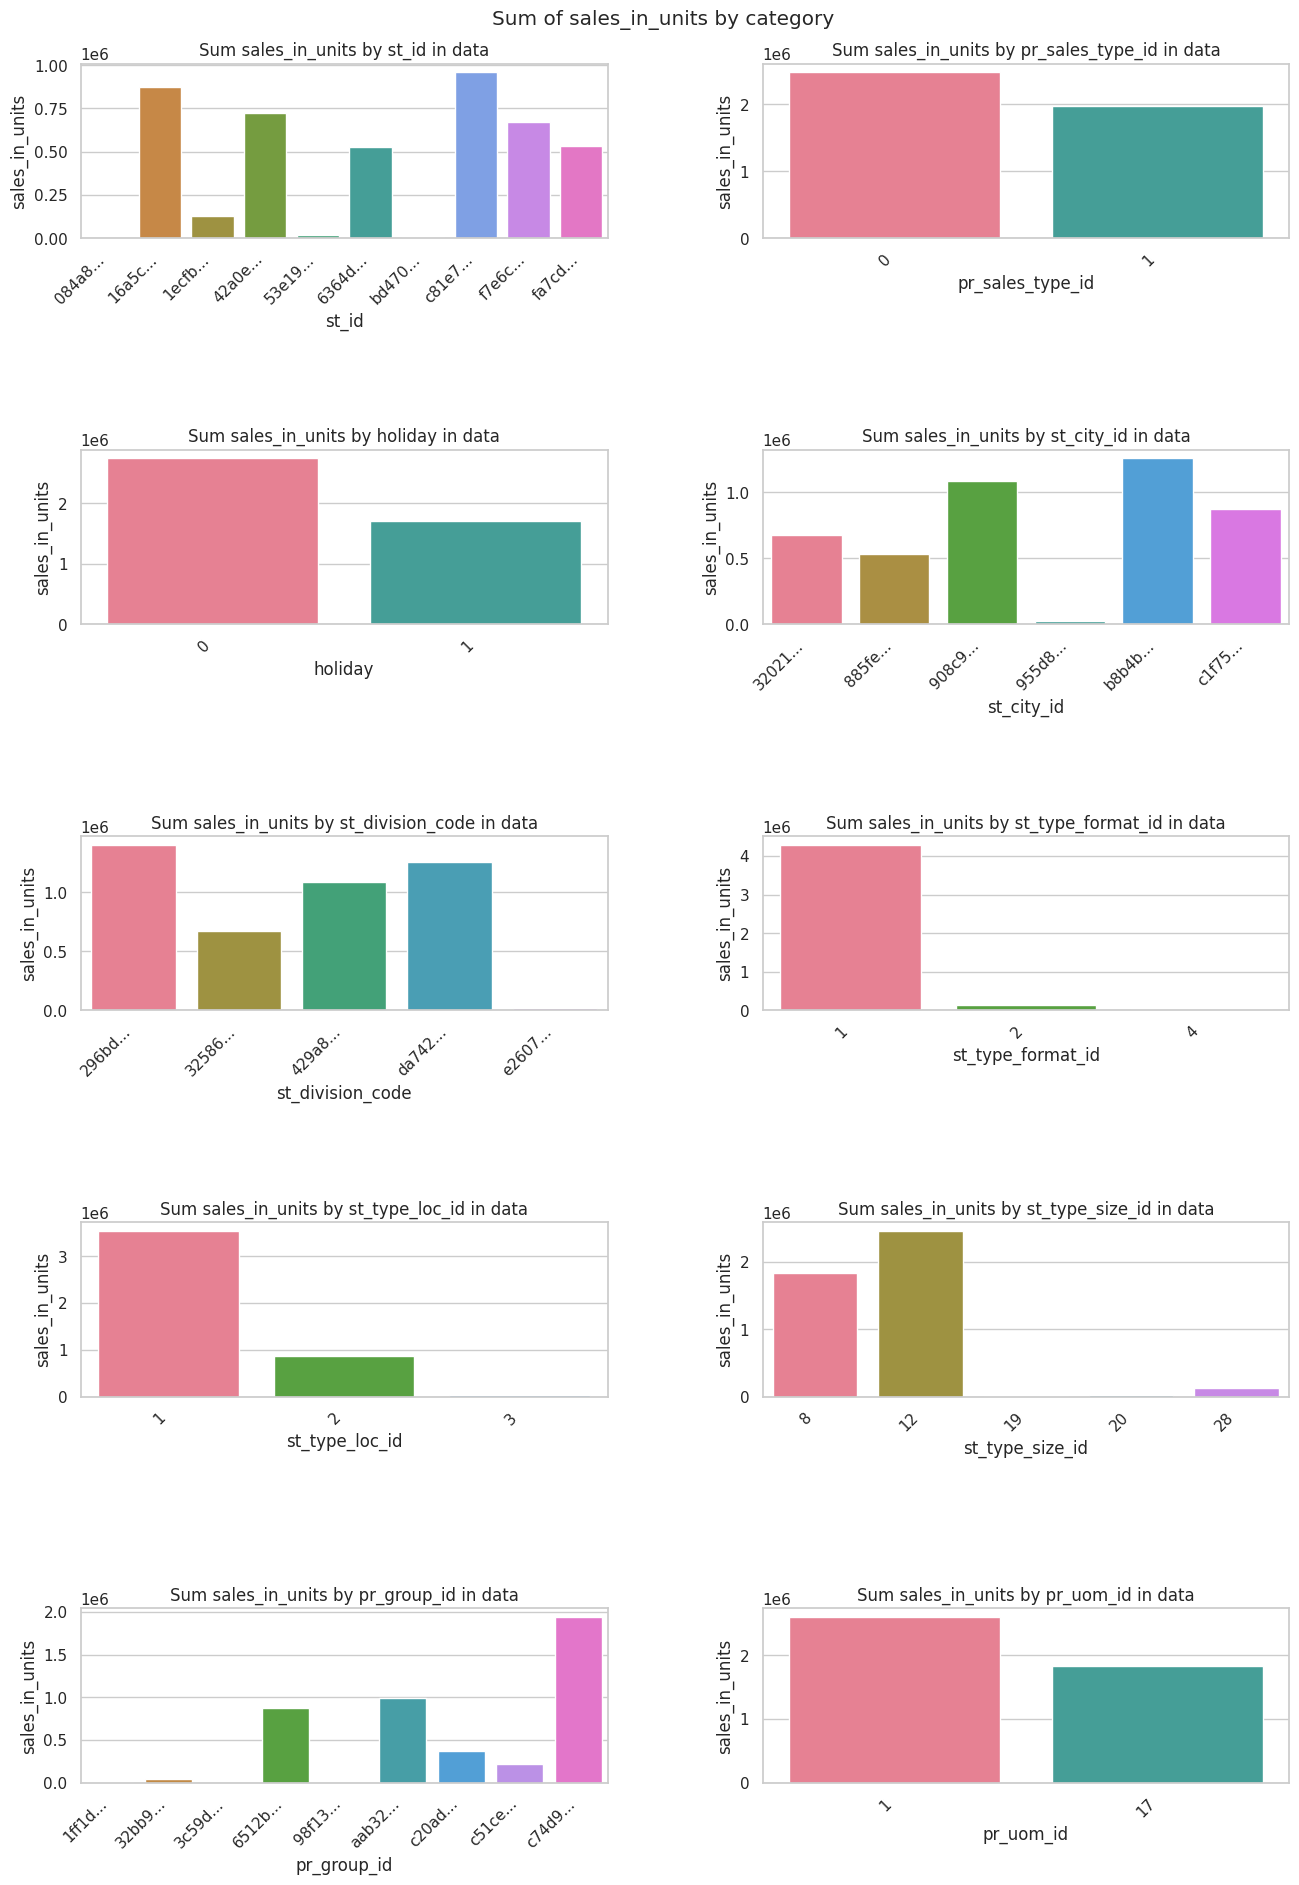

In [18]:
features_for_analysis = ['st_id',
                         'pr_sales_type_id',
                         'holiday',
                         'st_city_id',
                         'st_division_code',
                         'st_type_format_id',
                         'st_type_loc_id',
                         'st_type_size_id',
                         'pr_group_id',
                         'pr_uom_id']

fig, axs = plt.subplots(5, 2)
fig.tight_layout(pad=1.0)
fig.set_size_inches(14, 20, forward=True)

for i, col in enumerate(features_for_analysis):
    agg_df = main_df.groupby(col).agg({'pr_sales_in_units': 'sum'}).reset_index()
    agg_df = agg_df.sort_values(by=col)
    agg_df[col] = agg_df[col].astype(str)
    agg_df[col] = agg_df[col].apply(lambda x: x[:5] + '...' if len(x) > 5 else x)
    sns.barplot(x=col,
                y='pr_sales_in_units',
                data=agg_df,
                ax=axs[i // 2, i % 2],
                hue=col,
                palette=sns.color_palette("husl", len(agg_df)),
                legend=False)
    axs[i // 2, i % 2].set_title(f'Sum sales_in_units by {col} in data')
    axs[i // 2, i % 2].set_xticks(range(len(agg_df)))
    axs[i // 2, i % 2].set_xticklabels(agg_df[col], rotation=45, ha='right')
    axs[i // 2, i % 2].set_ylabel('sales_in_units')
fig.suptitle('Sum of sales_in_units by category')
plt.savefig(os.path.join(ASSETS_DIR, 'Sum of sales_in_units by category.png'))
plt.show()

Выводы и наблюдения:
- имеются магазины практически без продаж - возможно, их нужно исключить;
- есть город с практически нулевыми продажами - возможно, его необходимо исключить;
- есть дивизион с практически нулевыми продажами - возможно, его необходимо исключить;
- имеются форматы магазинов практически без продаж - возможно, их нужно исключить;
- имеются товарные группы практически без продаж - возможно, их нужно исключить;
- чтобы принять окончательное решение, необходимо детеальнее рассмотреть каждый параметр.

In [19]:
list_col = ['st_id',
            'st_city_id',
            'st_division_code',
            'st_type_format_id',
            'st_type_loc_id',
            'st_type_size_id',
            'pr_group_id']
for col in list_col:
    print(f'Распределение записей по столбцу ')
    print(main_df[col].value_counts())
    print()

Распределение записей по столбцу 
st_id
c81e728d9d4c2f636f067f89cc14862c    164779
16a5cdae362b8d27a1d8f8c7b78b4330    144017
42a0e188f5033bc65bf8d78622277c4e    128618
f7e6c85504ce6e82442c770f7c8606f0    114286
6364d3f0f495b6ab9dcf8d3b5c6e0b01    105372
fa7cdfad1a5aaf8370ebeda47a1ff1c3    100827
1ecfb463472ec9115b10c292ef8bc986     46219
53e19f3dbb211f20b20b45668303c1b6      9026
bd470ca955d9497bbcb808e59952fffc      2491
084a8a9aa8cced9175bd07bc44998e75        38
Name: count, dtype: int64

Распределение записей по столбцу 
st_city_id
b8b4b727d6f5d1b61fff7be687f7970f    233990
908c9a564a86426585b29f5335b619bc    210998
c1f75cc0f7fe269dd0fd9bd5e24f9586    144017
3202111cf90e7c816a472aaceb72b0df    114324
885fe656777008c335ac96072a45be15    100827
955d864a62659945cc9434898e275deb     11517
Name: count, dtype: int64

Распределение записей по столбцу 
st_division_code
296bd0cc6e735f9d7488ebc8fbc19130    244844
da742b3cfca5388aaf9af28a726a3c30    233990
429a86ff6336c144ddaf6144f52ab52c    

Выводы и наблюдения:
- во всех рассмотрненных признаках имеются значения с совсем небольшим количеством записей,
  <br>но пока их исключать нет необходимости;
- вернуться к ним можно на следующих шагах исследования.

#### target analysis

Описательные статистики целевой переменной:


count    815673.000000
mean          5.451414
std          13.864076
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

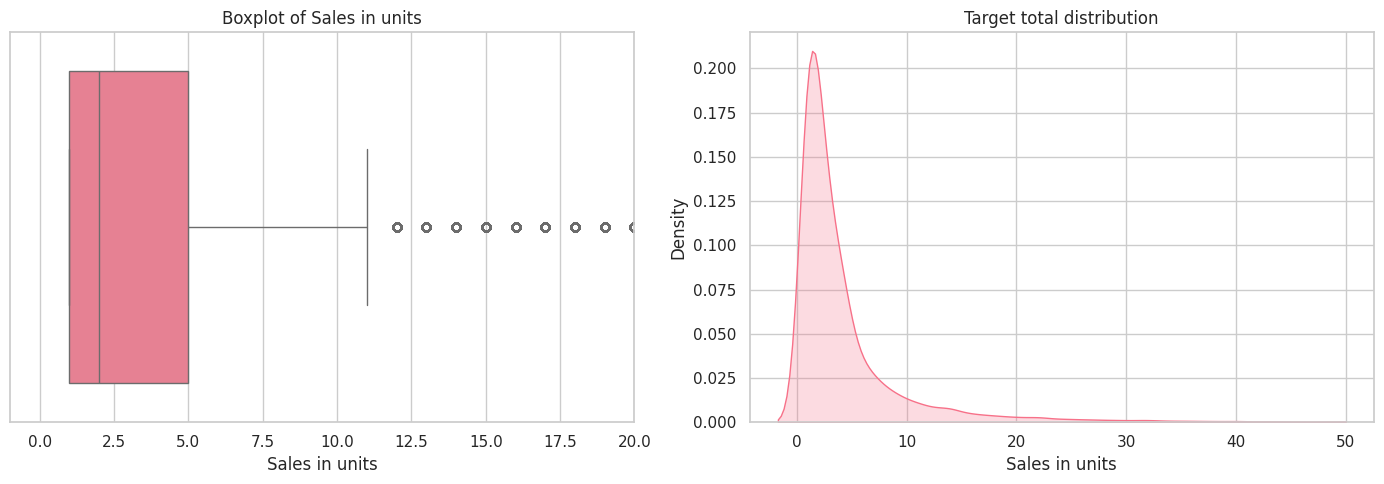

In [20]:
print('Описательные статистики целевой переменной:')
display(main_df['pr_sales_in_units'].describe())
print()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=main_df, x='pr_sales_in_units', ax=axs[0])
axs[0].set_xlim(-1, 20)
axs[0].set_xlabel('Sales in units')
axs[0].set_title('Boxplot of Sales in units')

sns.kdeplot(data=main_df, x='pr_sales_in_units', clip=(-10, 50), fill=True, ax=axs[1])
axs[1].set_xlabel('Sales in units')
axs[1].set_title('Target total distribution')

plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'Target total distribution and boxplot.png'))
plt.show()

Выводы и наблюдения:
- Cреднее значение больше медианного, наблюдается правосторонняя асимметрия;
- распределение целевой переменной `pr_sales_in_units` отличается от нормального.

#### feature correlation matrix

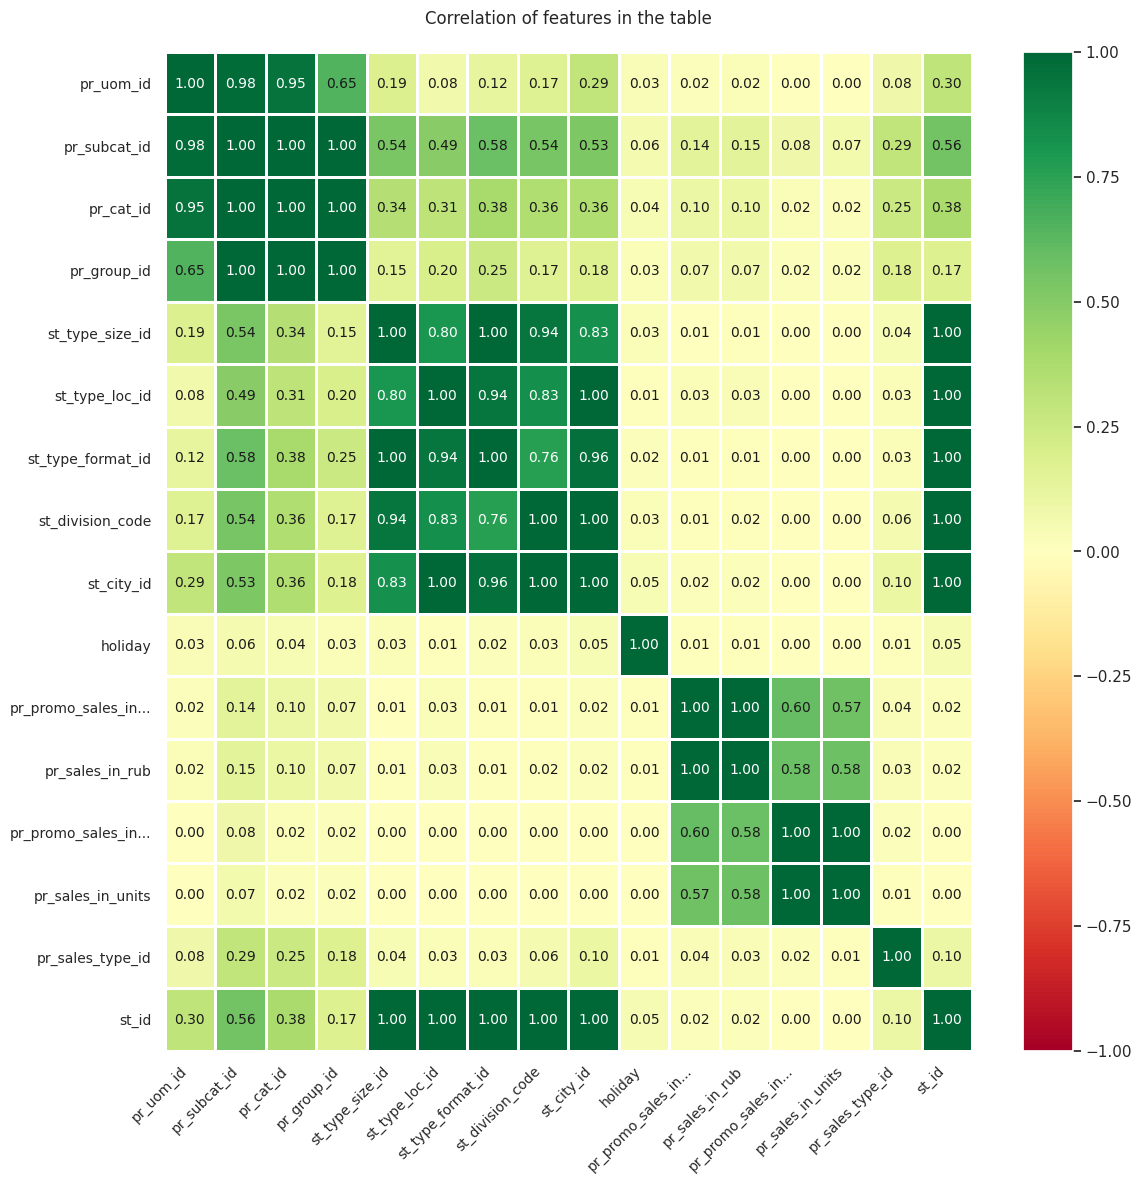

In [21]:
phik_overview = (
    main_df.drop(columns=['pr_sku_id', 'date', 'covid', 'st_is_active'])
    .phik_matrix(interval_cols=main_df.select_dtypes(include=['int', 'float'])))
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(12, 12))
plt.xticks(rotation=45, ha='right')
plt.title(f'Correlation of features in the table', fontsize=12, y=1.02)
plt.savefig(os.path.join(ASSETS_DIR, 'Features correlations.png'))
plt.tight_layout()

Выводы и наблюдения:
- группы признаков, у которых выявлены корреляции:
  - `st_id`, `st_type_size_id`, `st_type_loc_id`, `st_type_format_id`, `st_division_code`, `st_city_id`;
  - `pr_promo_sales_in_units`, `pr_sales_in_units`, `pr_sales_in_rub`, `pr_promo_sales_in_rub`;
  - `pr_uom_id`, `pr_subcat_id`, `pr_cat_id`;
- в каждой группе будет оставлен только один признак.

Удаление неинформативных и коррелированных признаков

In [22]:
clean_df = main_df.copy()
clean_df.drop(['st_is_active',
               'covid',
               'pr_promo_sales_in_units',
               'pr_sales_in_rub',
               'pr_promo_sales_in_rub',
               'pr_subcat_id',
               'pr_cat_id',
               'st_type_size_id',
               'st_type_loc_id',
               'st_type_format_id',
               'st_division_code',
               'st_city_id'],
              axis=1,
              inplace=True)

In [23]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815673 entries, 0 to 815672
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   st_id              815673 non-null  object        
 1   pr_sku_id          815673 non-null  object        
 2   date               815673 non-null  datetime64[ns]
 3   pr_sales_type_id   815673 non-null  int64         
 4   pr_sales_in_units  815673 non-null  float64       
 5   holiday            815673 non-null  int64         
 6   pr_group_id        815673 non-null  object        
 7   pr_uom_id          815673 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 49.8+ MB


#### distribution of target by date

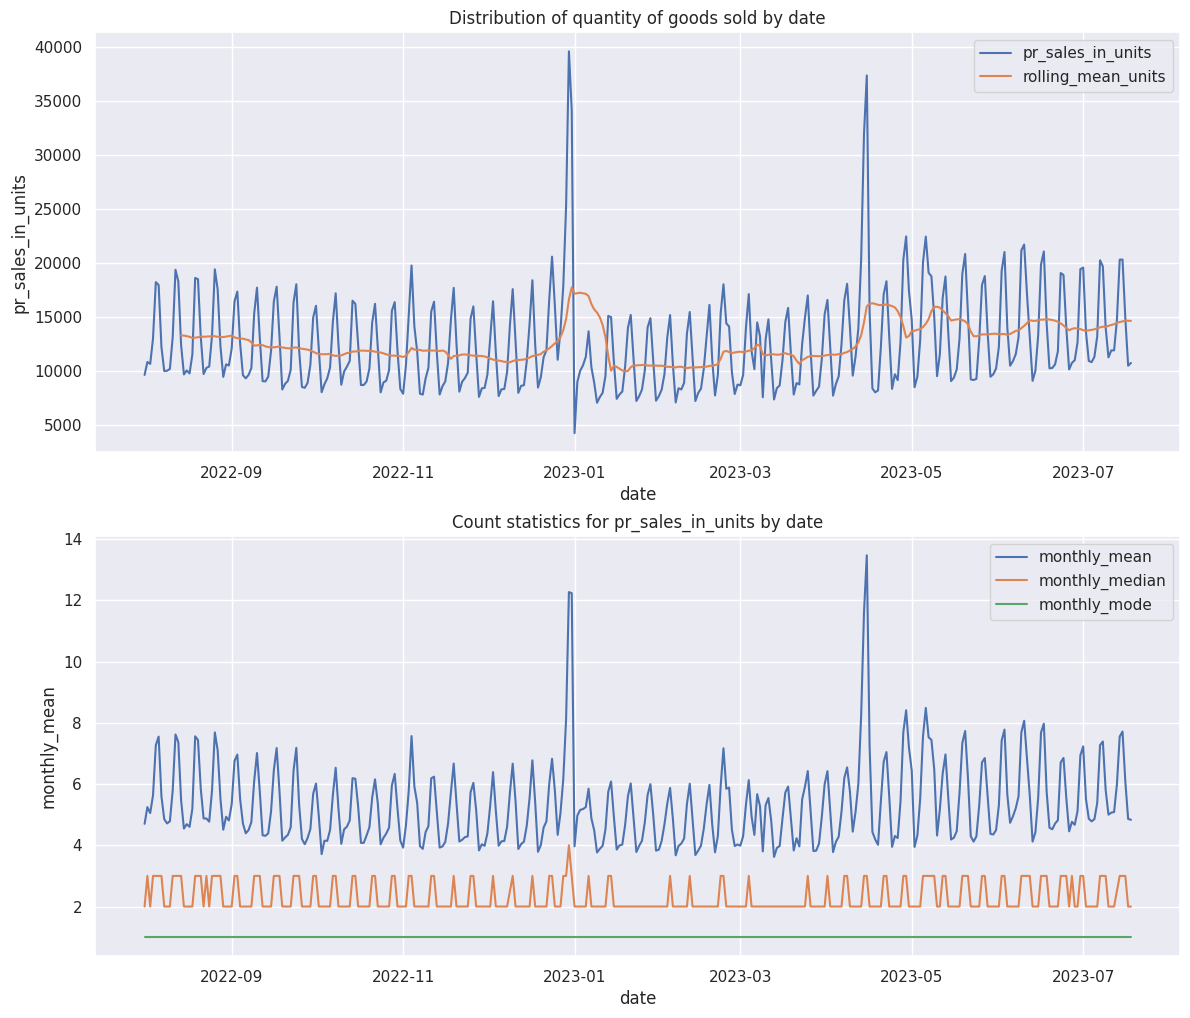

In [24]:
target_agg_by_date = clean_df[['date', 'pr_sales_in_units']].groupby(['date']).agg(['sum']).reset_index()
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = ['date', 'pr_sales_in_units']
target_agg_by_date['rolling_mean_units'] = target_agg_by_date['pr_sales_in_units'].rolling(14).mean()
x = 'date'
sales_columns = ['pr_sales_in_units', 'rolling_mean_units']
stats = ['mean', 'median', lambda x: x.mode().iloc[0]]

sales_monthly_agg = clean_df[[x] + [sales_columns[0]]].groupby([x]).agg(stats).reset_index()
sales_monthly_agg.columns = sales_monthly_agg.columns.droplevel()
sales_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

fig, axs = plt.subplots(2, 1, figsize=(14, 12))

for col in sales_columns:
    sns.lineplot(data=target_agg_by_date, x='date', y=col, label=col, ax=axs[0])
axs[0].set_title('Distribution of quantity of goods sold by date')
axs[0].legend()

for i, stat in enumerate(sales_monthly_agg.columns[1:]):
    sns.lineplot(data=sales_monthly_agg, x=x, y=stat, label=stat, ax=axs[1])
axs[1].set_title(f"Count statistics for {sales_columns[0]} by {x}")
axs[1].legend()

plt.savefig(os.path.join(ASSETS_DIR, 'Target statistics by date.png'))
plt.show()

Выводы и наблюдения:
- самые большие суммарные продажи в конце декабря, начеле января и в апреле,
  <br>это же демонстрирует и скользящее среднее;
- самое низкое значение продаж в начале января;
- медианное значение по месяцам колеблется в интервале от 2-х до 3-х;
- мода - везде равна единице.

#### resampling by sums of values per day

In [25]:
clean_df_dt = clean_df.set_index('date')
clean_df_resamp = clean_df_dt.resample('1D').sum()

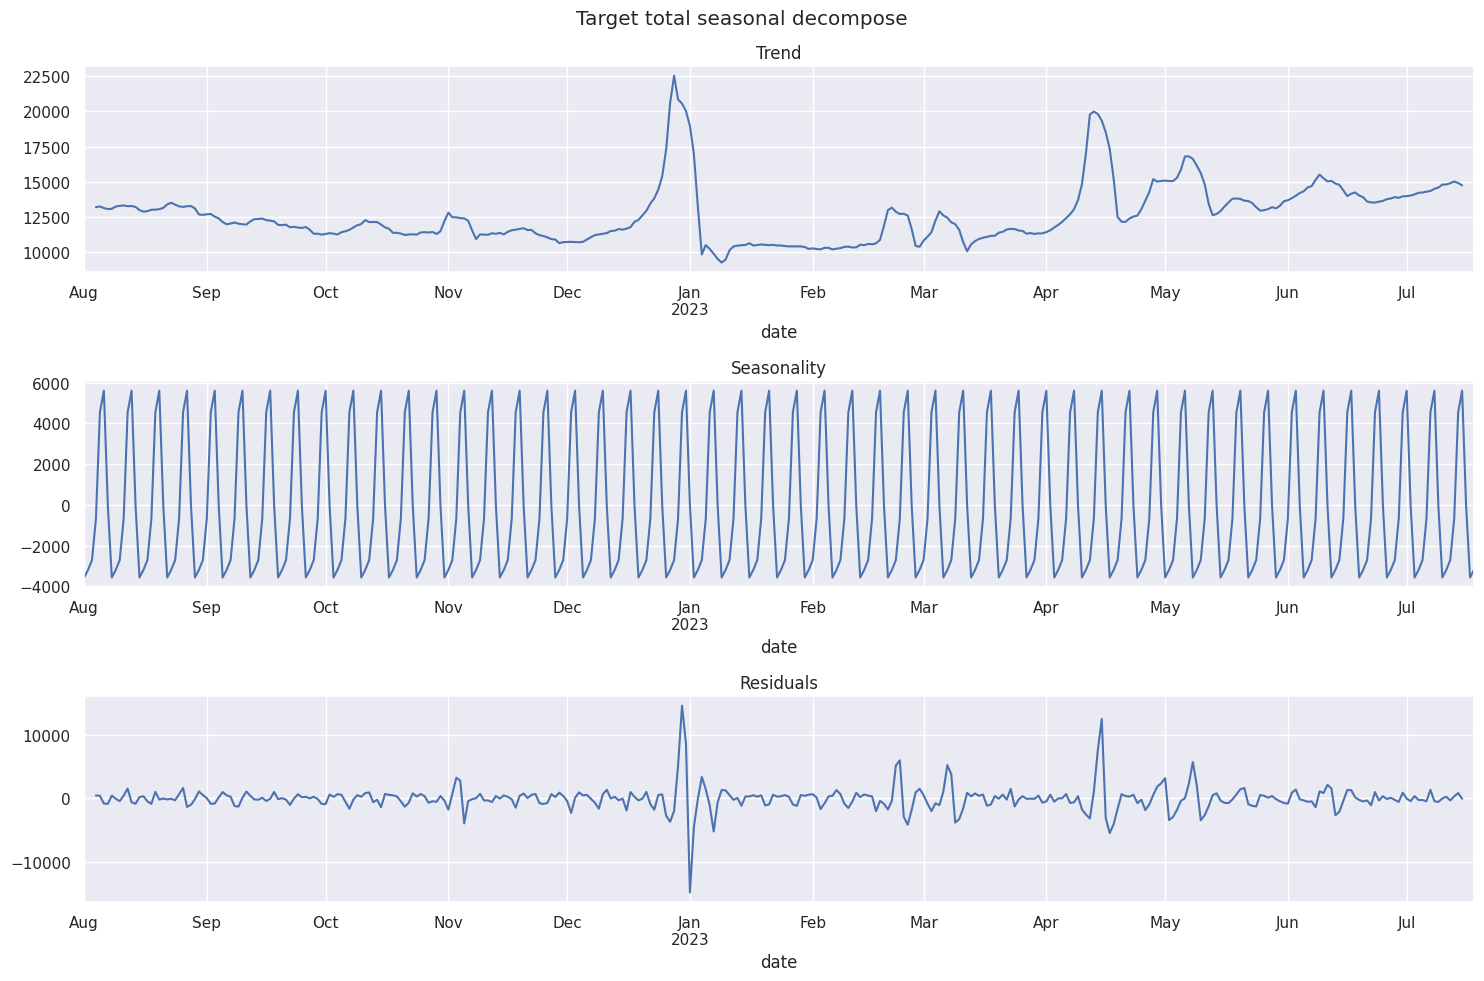

In [26]:
decomposed_units = seasonal_decompose(clean_df_resamp['pr_sales_in_units'])

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed_units.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.suptitle('Target total seasonal decompose')
plt.savefig(os.path.join(ASSETS_DIR, 'Target total seasonal decompose.png'))
plt.tight_layout()
plt.show()

Выводы и наблюдения:
- На графике тренда наблюдается, рост продаж в дни государственных праздников:
  <br>Новый год, 23 февраля, 8 марта, майские праздники, 12 июня - в эти дни образуются локальные пики;
- Самый большой пик продаж в конце декабря, в первые несколько дней января  спрос резко падает.
  <br>Это связано с подготовкой покупателей к корпоративам и празднованию Нового года.
- После первой декады апреля и до начала сентября продажи выше, чем в остальную часть года.
  <br>Это связано с сезоном пикников и  поездками на дачи.

#### study of seasonality over a fortnight interval

In [27]:
fortnight_season = clean_df_resamp['pr_sales_in_units']
fortnight_season = fortnight_season['2023-06-24':'2023-07-11']

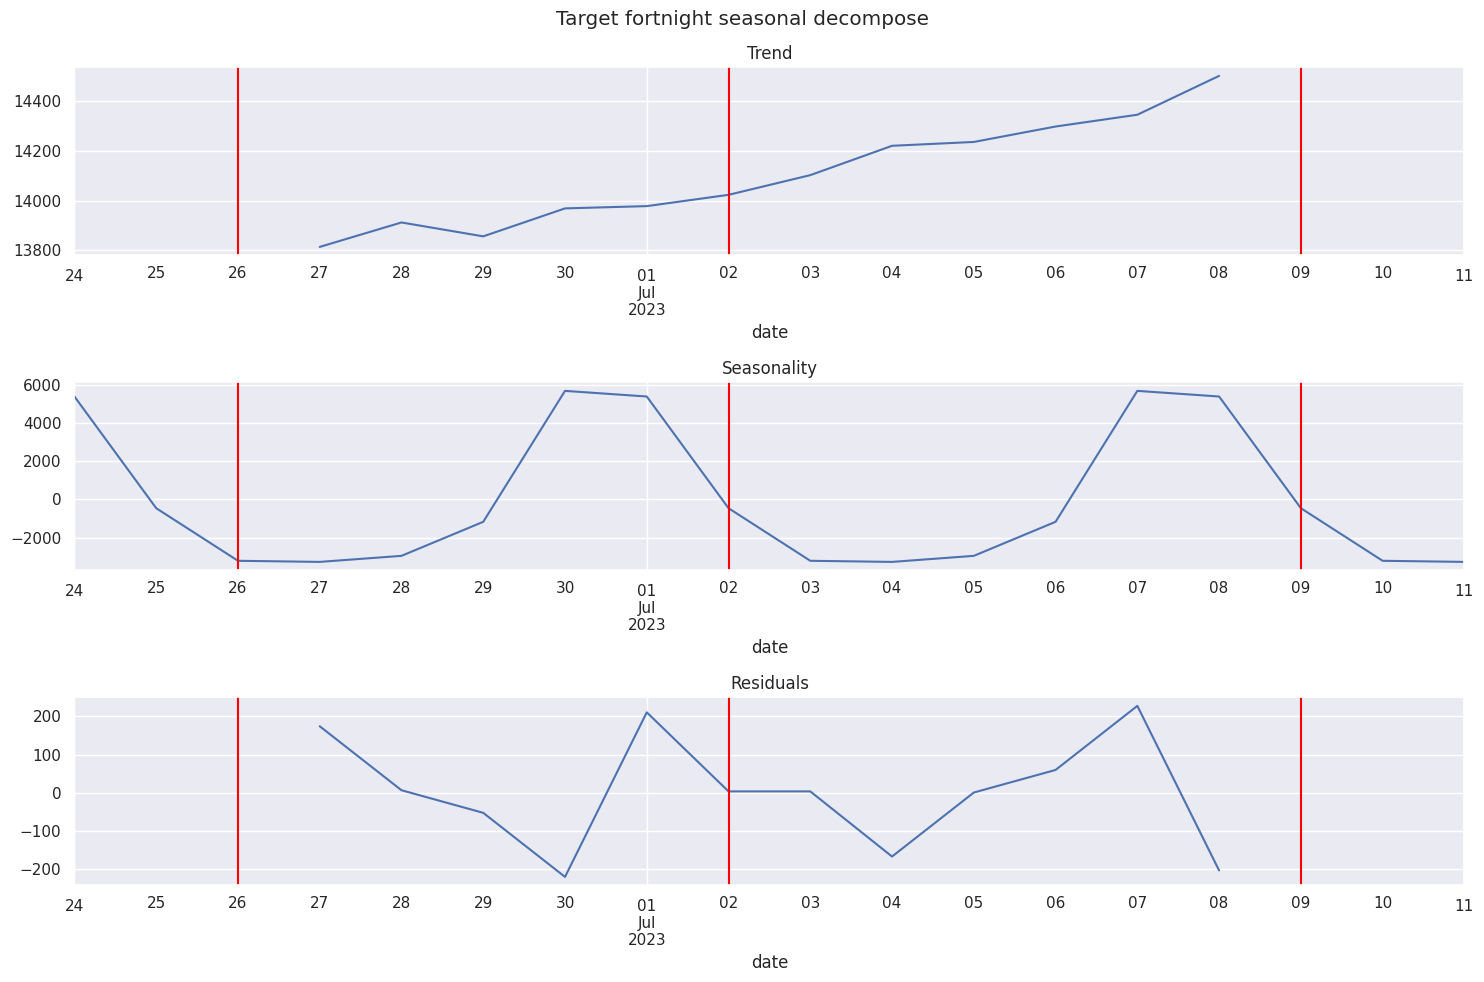

In [28]:
decomposed_week = seasonal_decompose(fortnight_season)

plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Trend')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Seasonality')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Residuals')

plt.suptitle('Target fortnight seasonal decompose')
plt.savefig(os.path.join(ASSETS_DIR, 'Target fortnight seasonal decompose.png'))
plt.tight_layout()
plt.show()

Выводы и наблюдения:
- При анализе тренда за 2 недели наблюдается, рост продаж в пятницу и субботу,
- в воскресенье отмечается спад.
- Уровень продаж в течение недели ниже, чем в пиковые дни.
- Клиенты чаще совершают покупки перед выходными днями и в выходные.

#### stationarity check

In [29]:
test = adfuller(clean_df_resamp['pr_sales_in_units'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']:
  print('есть единичные корни, ряд не стационарен')
else:
  print('единичных корней нет, можем предположить, что ряд стационарен')

adf:  -3.3035023987078924
p-value:  0.014722641217042629
Critical values:  {'1%': -3.4499043309021955, '5%': -2.870154885338925, '10%': -2.5713597190254385}
единичных корней нет, можем предположить, что ряд стационарен


Вывод по тесту Дики-Фуллера:
- Исходя из данного результата теста Дики-Фуллера, можно сделать вывод,
  <br>что временной ряд является стационарным, так как p-значение меньше уровня значимости 0.05,
  <br>и статистика теста меньше критических значений для всех уровней значимости.

### conclusions from the eda
- Данные предоставлены за период с 01.08.2022 по 18.07.2023
- Предоставленные датасеты объединены в один датафрейм
- К общему датафрейму добавлена информация о государственных праздниках и выходных днях в РФ
- Удалены записи по магазинам без маркера активности (действие согласовано с бизнесом): им соответствует 729 записей, что составляет 0.08% датасета.
- Распределение целевой переменной `pr_sales_in_units` отличается от нормального: наблюдается правосторонняя асимметрия
- Удалены данные с нулевыми продажами в шт и руб.
- Удалены записи с отрицательным значением целевого признака (действие согласовано с бизнесом)
- Удалены сильно коррелированные признаки
- Данные разложены на три составляющие (для этого осуществлён ресемплинг по одному дню) - сезонность, тренд и остаток:
  - наблюдается рост спроса перед праздничными днями (годовая сезонность)
  - рост спроса в выходные дни (недельная сезонность)
- Временной ряд может быть стационарен, о чём свидетельствует тест Дики-Фуллера, но наличие тренда и сезонности говорят об обратном

## Baseline

### data prepare

Деление данных на выборки

In [30]:
X_train, y_train, X_test, y_test = DatasetExplorer.data_splitting(dataset=clean_df_dt, pred_period=DAYS_PRED, target='pr_sales_in_units')

Размерности полученных выборок:


(781525, 6)

(781525,)

(34148, 6)

(34148,)

In [31]:
tscv = TimeSeriesSplit(n_splits=math.floor(X_train.shape[0] / X_test.shape[0]))
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=22, test_size=None)

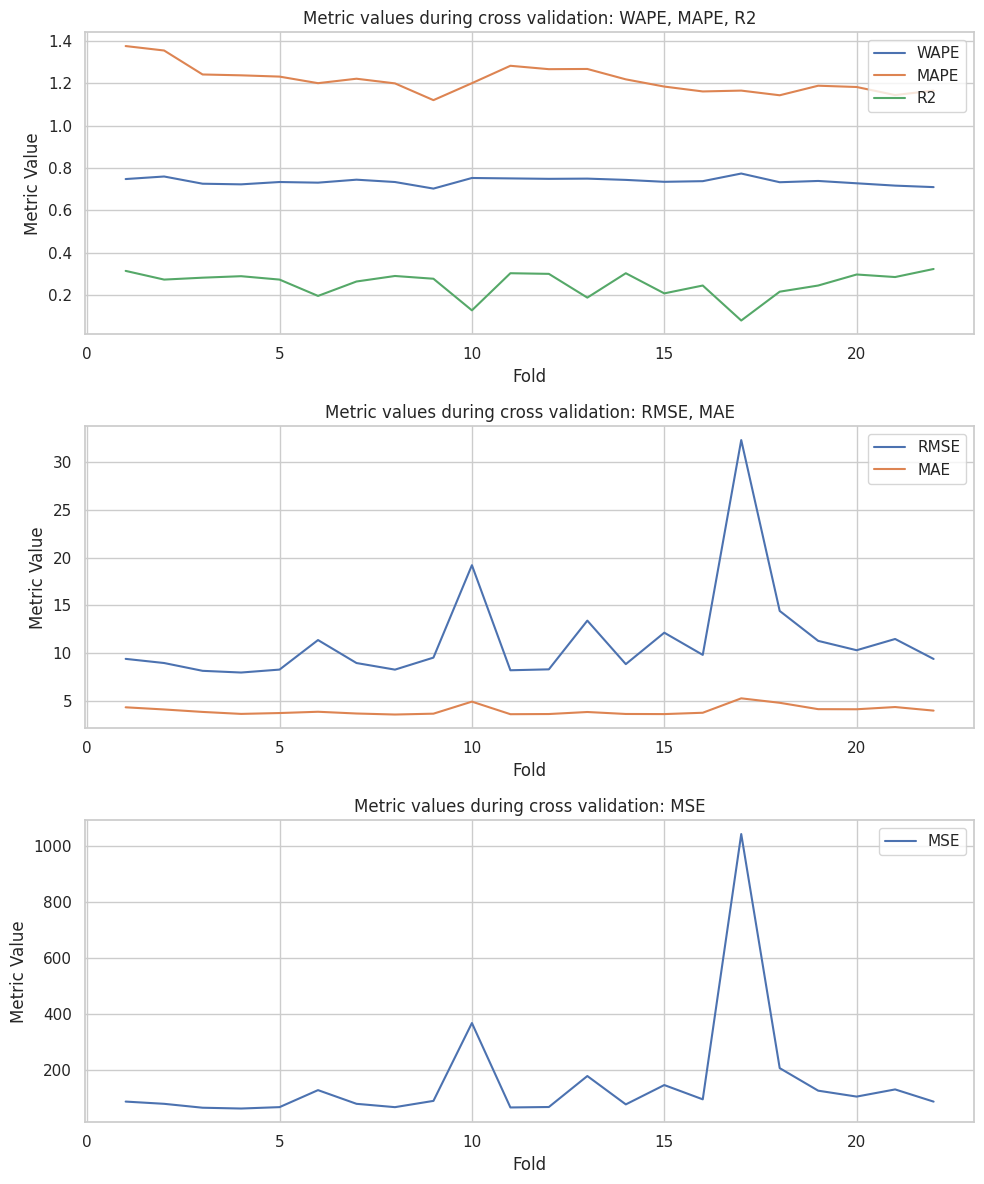

Средние значения метрик по кросс-валидации:


{'wape': 0.738,
 'mape': 1.216,
 'rmse': 11.354,
 'mae': 3.992,
 'mse': 156.518,
 'r2': 0.255}

In [9]:
valid_metrics, pipeline = DatasetExplorer.model_fitting(model_name='Baseline',
                                                        train_features=X_train,
                                                        train_labels=y_train,
                                                        assets_dir=ASSETS_DIR,
                                                        tscv=tscv,
                                                        params=None,
                                                        params_selection=False)

In [43]:
metadata = {"data_used": 'clean_df',
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn":"1.4.2"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
sales_explorer.model_logging(experiment_name=EXPERIMENT_NAME,
					         run_name='baseline_cv_registry',
					         registry_model='baseline_cv',
					         params=pipeline.named_steps['model'].get_params(),
					         metrics=valid_metrics,
					         model=pipeline.named_steps['model'],
					         train_data=X_train,
                             train_label=y_train,
					         assets_dir=ASSETS_DIR,
					         metadata=metadata,
					         code_paths=code_paths,
					         tsh=TRACKING_SERVER_HOST,
					         tsp=TRACKING_SERVER_PORT)

Successfully registered model 'baseline_cv'.
2024/05/16 22:18:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: baseline_cv, version 1
Created version '1' of model 'baseline_cv'.


Models and their metrics:


experiment_name              run_name   model_name  model_version  \
0  lenta_demand_forecast   baseline_0_registry     baseline              1   
1  lenta_demand_forecast  baseline_cv_registry  baseline_cv              1   

    wape   mape    rmse    mae      mse     r2  
0  0.891  1.811  12.548  5.117  157.442  0.045  
1  0.893  1.778  12.801  4.832  191.194  0.031

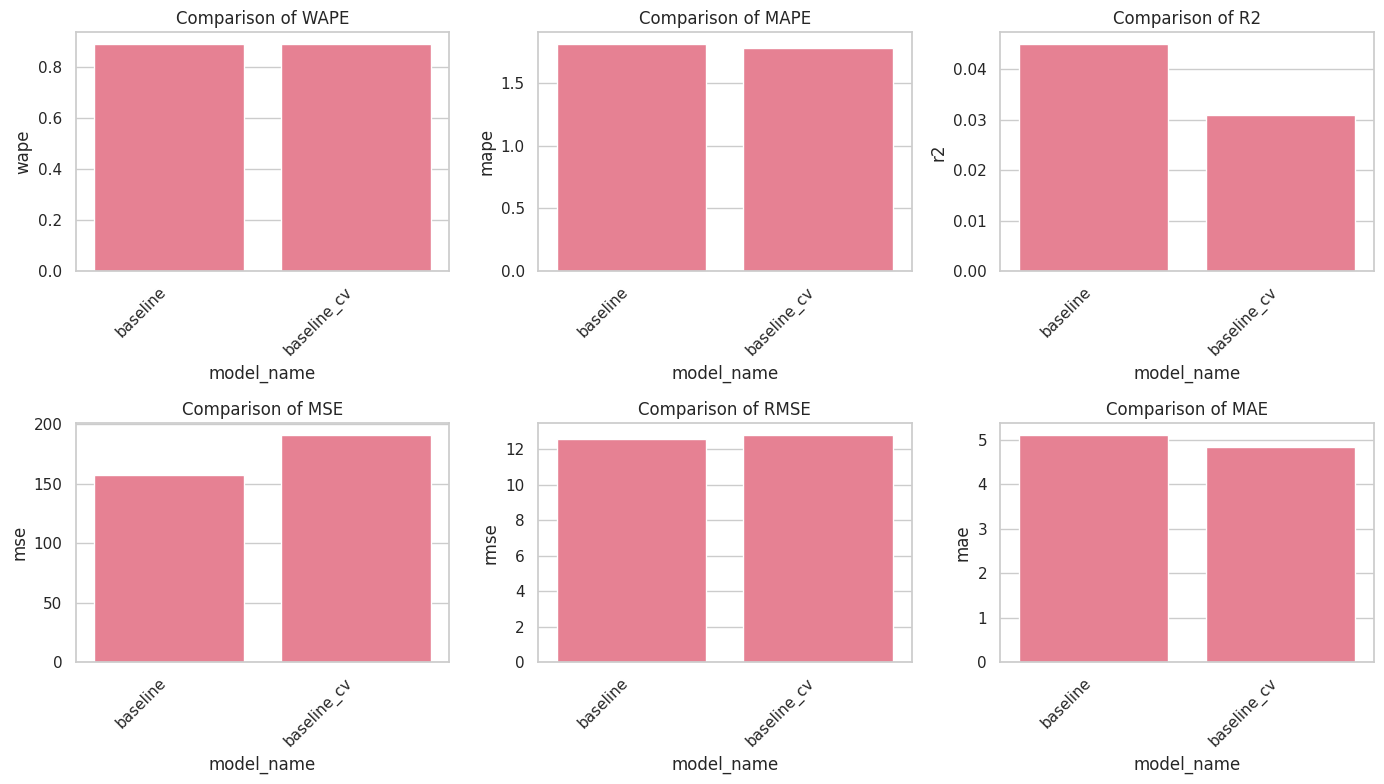

In [44]:
sales_explorer.models_comparison(connection=connection,
                                 postgres_credentials=postgres_credentials,
                                 experiment_name=EXPERIMENT_NAME,
                                 assets_dir=None)

Выводы и наблюдения:
- данные разделены на выборки;
- создан объект `TimeSeriesSplit`;
- в качестве базовой модели принята модель `LinearRegression`;
- значение метрики на базовой модели: `wape = 0.893`

## Feature engineering

In [32]:
df_new_feat = DatasetExplorer.feature_engineering(dataset=clean_df,
                                                  target='pr_sales_in_units',
                                                  date_column='date',
                                                  group_columns=['st_id', 'pr_sku_id', 'pr_sales_type_id'],
                                                  window_size=14)

Верхние строки набора данных:


st_id  \
date                                           
2022-08-01  6364d3f0f495b6ab9dcf8d3b5c6e0b01   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
2022-08-01  1ecfb463472ec9115b10c292ef8bc986   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   

                                   pr_sku_id  pr_sales_type_id  \
date                                                             
2022-08-01  e4522fed8db6c62127eedea2fe1634bd                 0   
2022-08-01  98d292620ce4e8087db271b691e28a4c                 0   
2022-08-01  b6871caaf03565202e4c3bafef2af7c6                 0   
2022-08-01  71548e4c1872755e6873416c2f49afe4                 0   
2022-08-01  67797f1f0f02ec5ccd5e3abd2d4e5b81                 0   

            pr_sales_in_units  holiday                       pr_group_id  \
date                                                                       
2022-08-01                1.0        0  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01                2.0        0  c51ce410c124a10e0db5e4b97fc2af39   
2022-08-01                1.0        0  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01                1.0        0  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01               17.0        0  aab3238922bcc25a6f606eb525ffdc56   

            pr_uom_id  rolling_mean_14d_lag3  rolling_mean_14d_lag7  \
date                                                                  
2022-08-01         17                    6.0                    6.0   
2022-08-01          1                    2.0                    1.0   
2022-08-01          1                    1.0                    3.0   
2022-08-01          1                    1.0                    4.0   
2022-08-01          1                    2.0                    6.0   

            rolling_mean_14d_lag11  rolling_mean_14d_lag14  month  day  \
date                                                                     
2022-08-01                     1.0                     1.0      8    1   
2022-08-01                     2.0                     3.0      8    1   
2022-08-01                     2.0                     4.0      8    1   
2022-08-01                     1.0                     1.0      8    1   
2022-08-01                     6.0                     2.0      8    1   

            day_of_year  day_of_week  quarter  is_month_start  is_month_end  
date                                                                         
2022-08-01          213            0        3               1             0  
2022-08-01          213            0        3               1             0  
2022-08-01          213            0        3               1             0  
2022-08-01          213            0        3               1             0  
2022-08-01          213            0        3               1             0

Выводы и заключения:
- сгенерированы новые признаки из составляющих даты;
- сгенерированы новые признаки из лагов скользящего среднего за 14 дней.

## Linear Regression with all features

In [33]:
X_train, y_train, X_test, y_test = DatasetExplorer.data_splitting(dataset=df_new_feat,
                                                                  pred_period=DAYS_PRED,
                                                                  target='pr_sales_in_units')

Размерности полученных выборок:


(781511, 17)

(781511,)

(34148, 17)

(34148,)

In [34]:
tscv = TimeSeriesSplit(n_splits=math.floor(X_train.shape[0] / X_test.shape[0]))
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=22, test_size=None)

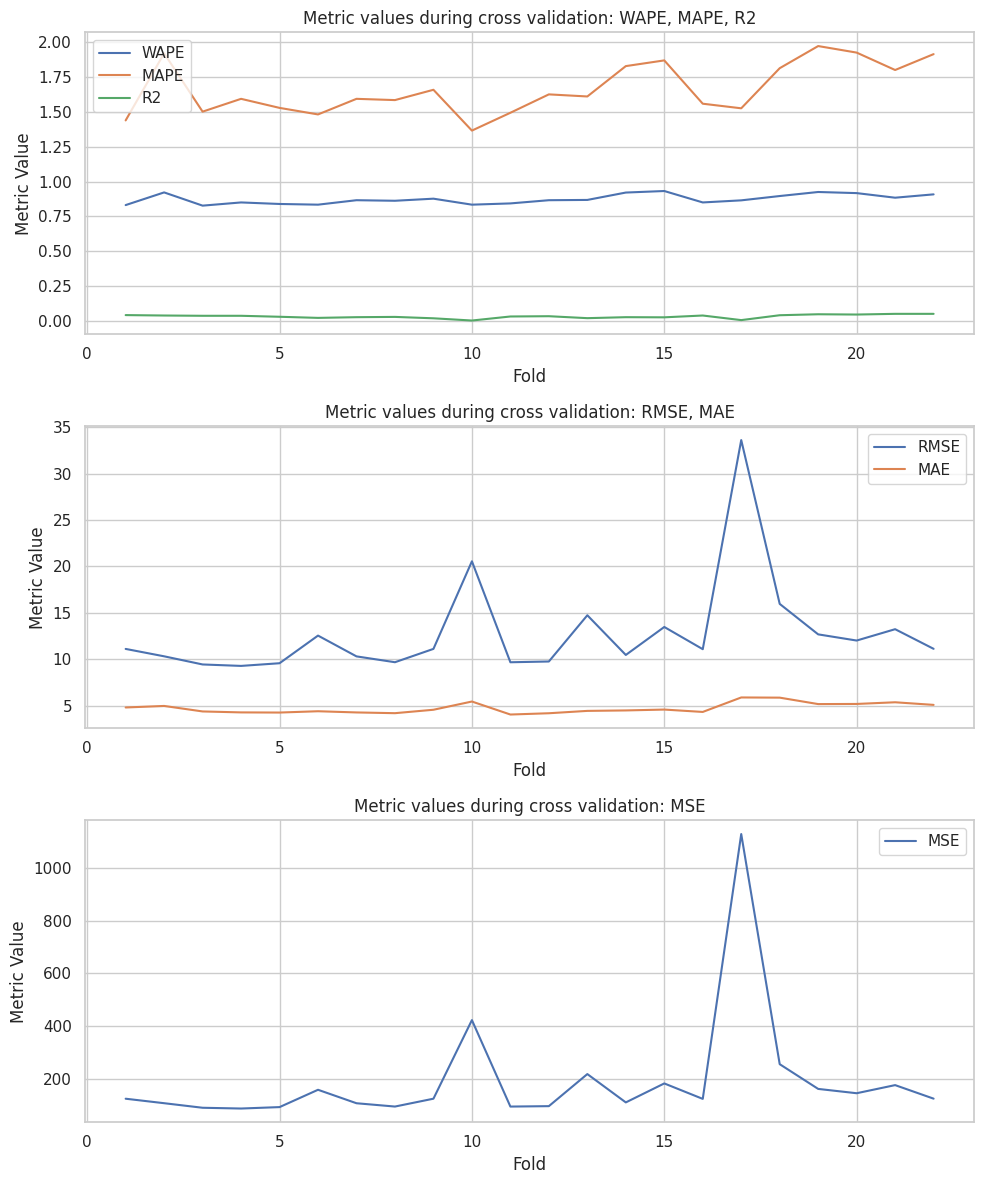

Средние значения метрик по кросс-валидации:


{'wape': 0.874,
 'mape': 1.664,
 'rmse': 12.801,
 'mae': 4.726,
 'mse': 191.185,
 'r2': 0.031}

In [13]:
valid_metrics, pipeline = DatasetExplorer.model_fitting(model_name='Linear Regression',
                                                        train_features=X_train.drop(['pr_sku_id'], axis=1),
                                                        train_labels=y_train,
                                                        assets_dir=None,
                                                        tscv=tscv,
                                                        params=None,
                                                        params_selection=False)

In [112]:
metadata = {"data_used": 'df_new_feat',
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn":"1.4.2"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
sales_explorer.model_logging(experiment_name=EXPERIMENT_NAME,
					         run_name='linreg_cv_0_registry',
					         registry_model='linreg_cv',
					         params=pipeline.named_steps['model'].get_params(),
					         metrics=valid_metrics,
					         model=pipeline.named_steps['model'],
					         train_data=X_train,
                             train_label=y_train,
					         assets_dir=ASSETS_DIR,
					         metadata=metadata,
					         code_paths=code_paths,
					         tsh=TRACKING_SERVER_HOST,
					         tsp=TRACKING_SERVER_PORT)

Successfully registered model 'linreg_cv'.
2024/05/17 18:42:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: linreg_cv, version 1
Created version '1' of model 'linreg_cv'.


Models and their metrics:


experiment_name              run_name   model_name  model_version  \
0  lenta_demand_forecast  linreg_cv_0_registry    linreg_cv              1   
1  lenta_demand_forecast   baseline_0_registry     baseline              1   
2  lenta_demand_forecast  baseline_cv_registry  baseline_cv              1   

    wape   mape    rmse    mae      mse     r2  
0  0.874  1.664  12.801  4.727  191.186  0.031  
1  0.891  1.811  12.548  5.117  157.442  0.045  
2  0.893  1.778  12.801  4.832  191.194  0.031

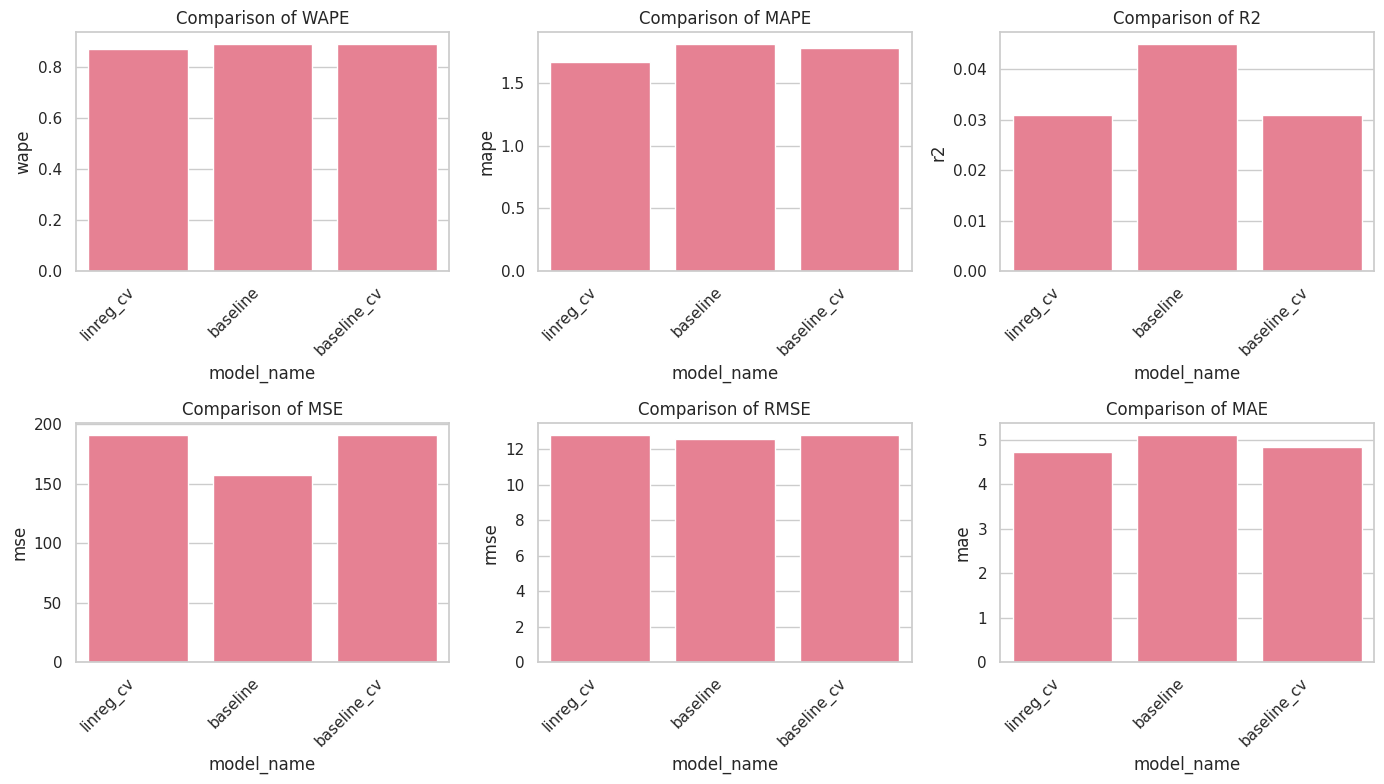

In [113]:
sales_explorer.models_comparison(connection=connection,
                                 postgres_credentials=postgres_credentials,
                                 experiment_name=EXPERIMENT_NAME,
                                 assets_dir=None)

Выводы и наблюдения:
- модель линейной регрессии, обученная на наборе данных с добавленными признаками,
  <br>показала чуть лучший результат: `wape = 0.874`

## LightGBM

/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


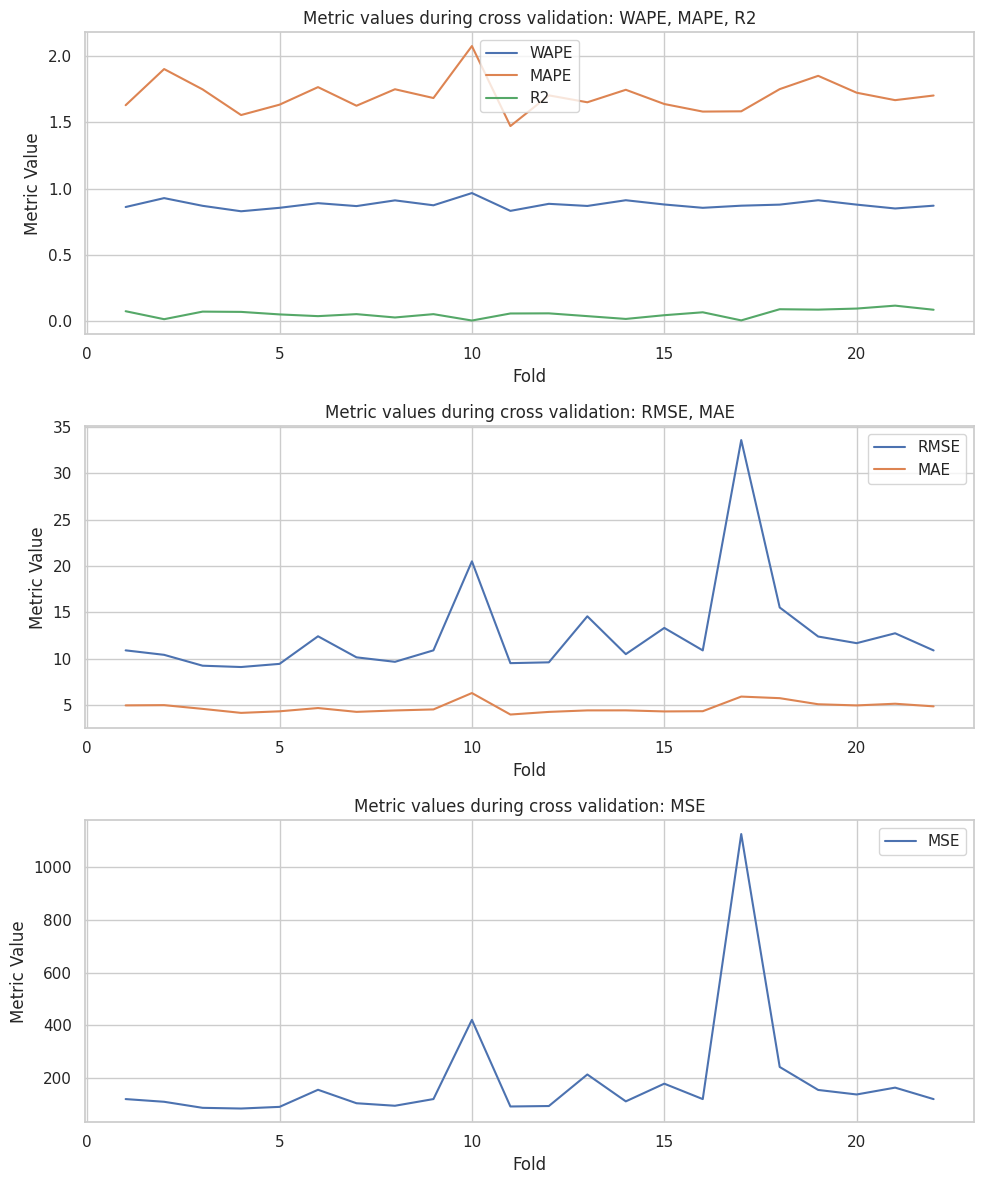

Средние значения метрик по кросс-валидации:


{'wape': 0.879,
 'mape': 1.699,
 'rmse': 12.634,
 'mae': 4.763,
 'mse': 187.008,
 'r2': 0.058}

In [14]:
lgb_params = {'num_iterations': 100,
              'learning_rate': 0.1,
              'num_leaves': 31,
              'boosting': 'gbdt',
              'seed': RANDOM_STATE,
              'num_threads': 0}
lgb_metrics, lgb_pipeline = DatasetExplorer.model_fitting(model_name='LGBM',
                                                          train_features=X_train.drop(['pr_sku_id'], axis=1),
                                                          train_labels=y_train,
                                                          assets_dir=None,
                                                          tscv=tscv,
                                                          params=lgb_params,
                                                          params_selection=False)

In [19]:
metadata = {"data_used": "df_new_feat",
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn": "1.4.2",
                                 "lightgbm": "4.4.0"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
sales_explorer.model_logging(experiment_name=EXPERIMENT_NAME,
					         run_name='lgbm_0_registry',
					         registry_model='lgbm_base',
					         params=lgb_pipeline.named_steps['model'].get_params(),
					         metrics=lgb_metrics,
					         model=lgb_pipeline.named_steps['model'],
					         train_data=X_train,
                             train_label=y_train,
					         assets_dir=ASSETS_DIR,
					         metadata=metadata,
					         code_paths=code_paths,
					         tsh=TRACKING_SERVER_HOST,
					         tsp=TRACKING_SERVER_PORT)

[autoreload of regression_research_class failed: Traceback (most recent call last):
  File "/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/denis/Documents/main_venv/demand_forecast_lenta/regression_research_class.py", line 30, in <module>
    class DatasetExplorer:
  File "/home/denis/Documents/main_venv/demand_forecast_lenta/r

Models and their metrics:


experiment_name              run_name   model_name  model_version  \
0  lenta_demand_forecast  linreg_cv_0_registry    linreg_cv              1   
1  lenta_demand_forecast       lgbm_0_registry    lgbm_base              1   
2  lenta_demand_forecast   baseline_0_registry     baseline              1   
3  lenta_demand_forecast  baseline_cv_registry  baseline_cv              1   

    wape   mape    rmse    mae      mse     r2  
0  0.874  1.664  12.801  4.727  191.186  0.031  
1  0.879  1.699  12.634  4.763  187.008  0.058  
2  0.891  1.811  12.548  5.117  157.442  0.045  
3  0.893  1.778  12.801  4.832  191.194  0.031

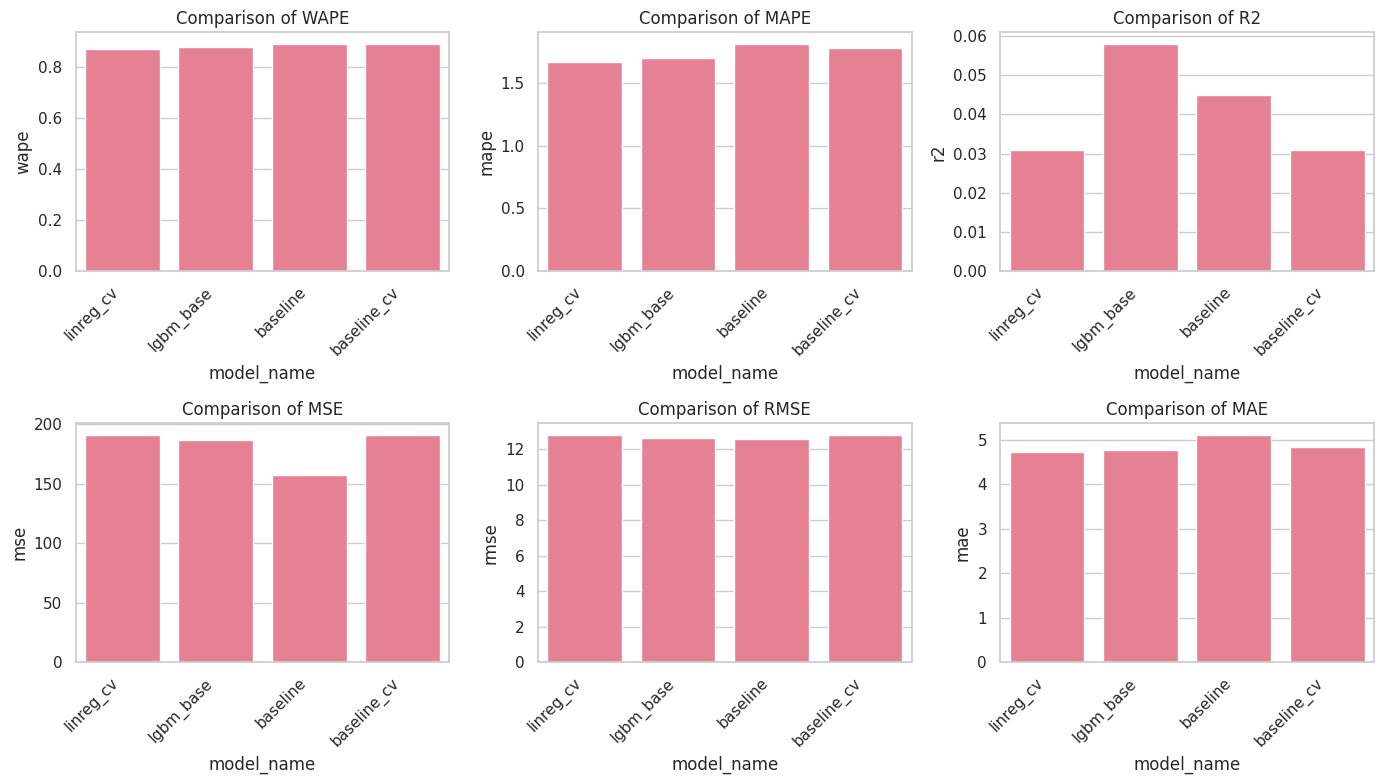

In [15]:
DatasetExplorer.models_comparison(connection=connection,
                                  postgres_credentials=postgres_credentials,
                                  experiment_name=EXPERIMENT_NAME,
                                  assets_dir=None)

Выводы и наблюдения:

- модель градиентного бустинга, обученная на наборе данных с гиперпараметрами по умолчанию,
  <br>показала не очень хороший результат: `wape = 0.879`

## Random Forest

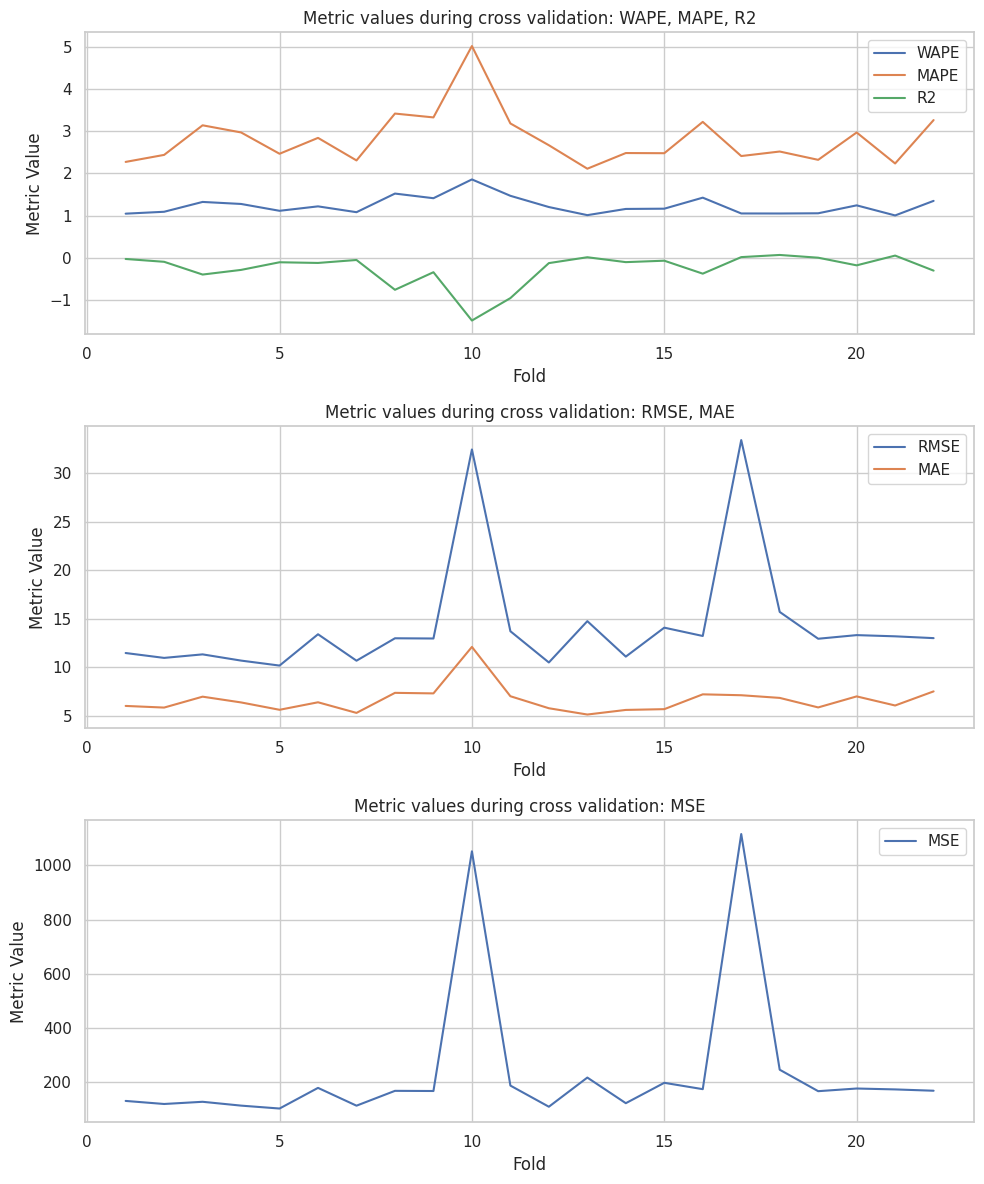

Средние значения метрик по кросс-валидации:


{'wape': 1.234,
 'mape': 2.821,
 'rmse': 14.377,
 'mae': 6.67,
 'mse': 243.111,
 'r2': -0.254}

In [16]:
rf_params = {'n_estimators': 100,
             'criterion': 'squared_error',
             'max_depth': None,
             'bootstrap': True,
             'random_state': RANDOM_STATE,
             'n_jobs': -1}
rf_metrics, rf_pipeline = DatasetExplorer.model_fitting(model_name='Random Forest',
                                                        train_features=X_train.drop(['pr_sku_id'], axis=1),
                                                        train_labels=y_train,
                                                        assets_dir=ASSETS_DIR,
                                                        tscv=tscv,
                                                        params=rf_params,
                                                        params_selection=False)

In [23]:
metadata = {"data_used": "df_new_feat",
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn": "1.4.2"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
DatasetExplorer.model_logging(experiment_name=EXPERIMENT_NAME,
				   	          run_name='rf_0_registry',
					          registry_model='rf_base',
					          params=rf_pipeline.named_steps['model'].get_params(),
					          metrics=rf_metrics,
					          model=rf_pipeline.named_steps['model'],
					          train_data=X_train,
                              train_label=y_train,
					          assets_dir=ASSETS_DIR,
					          metadata=metadata,
					          code_paths=code_paths,
					          tsh=TRACKING_SERVER_HOST,
					          tsp=TRACKING_SERVER_PORT)

2024/06/25 18:00:35 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.14.1, required: mlflow==2.12.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
Successfully registered model 'rf_base'.
2024/06/25 18:00:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: rf_base, version 1
Created version '1' of model 'rf_base'.


Models and their metrics:


experiment_name              run_name   model_name  model_version  \
0  lenta_demand_forecast  linreg_cv_0_registry    linreg_cv              1   
1  lenta_demand_forecast       lgbm_0_registry    lgbm_base              1   
2  lenta_demand_forecast   baseline_0_registry     baseline              1   
3  lenta_demand_forecast  baseline_cv_registry  baseline_cv              1   
4  lenta_demand_forecast         rf_0_registry      rf_base              1   

    wape   mape    rmse    mae      mse     r2  
0  0.874  1.664  12.801  4.727  191.186  0.031  
1  0.879  1.699  12.634  4.763  187.008  0.058  
2  0.891  1.811  12.548  5.117  157.442  0.045  
3  0.893  1.778  12.801  4.832  191.194  0.031  
4  1.234  2.821  14.377  6.670  243.111 -0.254

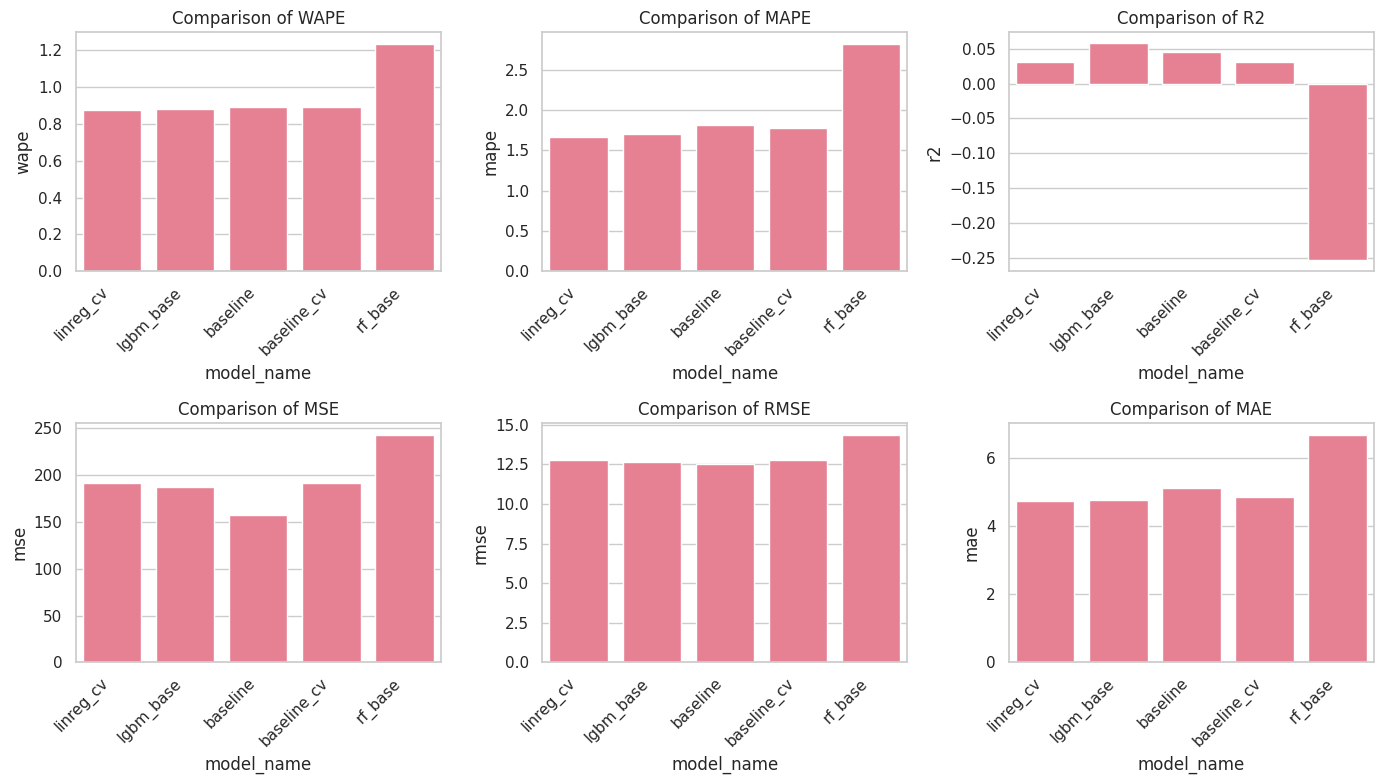

In [24]:
DatasetExplorer.models_comparison(connection=connection,
                                  postgres_credentials=postgres_credentials,
                                  experiment_name=EXPERIMENT_NAME,
                                  assets_dir=None)

Выводы и наблюдения:

- модель  случайного леса, обученная на наборе данных с гиперпараметрами по умолчанию,
  <br>делает предсказания, превышающие истинные значения, что неприемлемо для Заказчика

## LightGBM with Randomized Search

/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 781511, number of used features: 16
[LightGBM] [Info] Start training from score 5.427720


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


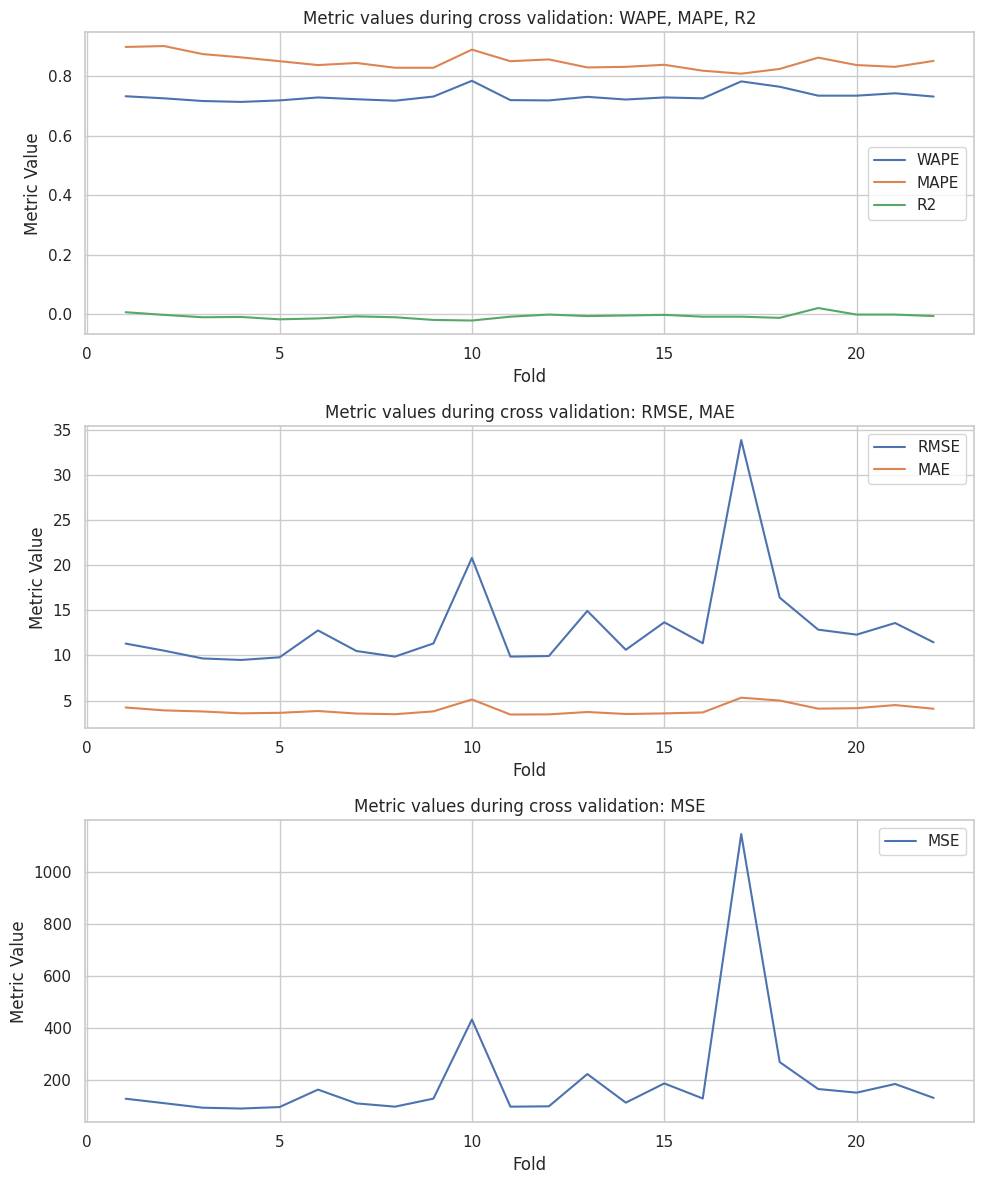

Средние значения метрик по кросс-валидации:


{'wape': 0.733,
 'mape': 0.849,
 'rmse': 13.037,
 'mae': 3.979,
 'mse': 197.415,
 'r2': -0.007}

CPU times: user 1d 9h 22min 15s, sys: 3min 13s, total: 1d 9h 25min 28s
Wall time: 4h 36min 9s


In [24]:
%%time
gb_params = {'model__num_iterations': np.arange(100, 1001, 100),
             'model__learning_rate': [0.01, 0.05, 0.1],
             'model__num_leaves': np.arange(31, 62, 5),
             'model__boosting_type': ['gbdt', 'dart'],
             'model__seed': [RANDOM_STATE],
             'model__num_threads': [0],
             'model__reg_lambda': np.arange(0, 7, 2)}
gb_metrics, gb_pipeline = DatasetExplorer.model_fitting(model_name='LGBM',
                                                        train_features=X_train.drop(['pr_sku_id'], axis=1),
                                                        train_labels=y_train,
                                                        assets_dir=ASSETS_DIR,
                                                        tscv=tscv,
                                                        params=gb_params,
                                                        params_selection=True)

In [30]:
metadata = {"data_used": "df_new_feat",
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn": "1.4.2",
                                 "lightgbm": "4.4.0"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
DatasetExplorer.model_logging(experiment_name=EXPERIMENT_NAME,
				   	          run_name='lgbm_rs_registry',
					          registry_model='lgbm_rs',
					          params=gb_pipeline.named_steps['model'].get_params(),
					          metrics=gb_metrics,
					          model=gb_pipeline.named_steps['model'],
					          train_data=X_train,
                              train_label=y_train,
					          assets_dir=ASSETS_DIR,
					          metadata=metadata,
					          code_paths=code_paths,
					          tsh=TRACKING_SERVER_HOST,
					          tsp=TRACKING_SERVER_PORT)

2024/06/26 15:52:27 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.14.1, required: mlflow==2.12.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
Successfully registered model 'lgbm_rs'.
2024/06/26 15:52:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: lgbm_rs, version 1
Created version '1' of model 'lgbm_rs'.


Models and their metrics:


experiment_name              run_name   model_name  model_version  \
0  lenta_demand_forecast         rf_0_registry      rf_base              1   
1  lenta_demand_forecast  baseline_cv_registry  baseline_cv              1   
2  lenta_demand_forecast   baseline_0_registry     baseline              1   
3  lenta_demand_forecast       lgbm_0_registry    lgbm_base              1   
4  lenta_demand_forecast  linreg_cv_0_registry    linreg_cv              1   
5  lenta_demand_forecast      lgbm_rs_registry      lgbm_rs              1   

    wape   mape    rmse    mae      mse     r2  
0  1.234  2.821  14.377  6.670  243.111 -0.254  
1  0.893  1.778  12.801  4.832  191.194  0.031  
2  0.891  1.811  12.548  5.117  157.442  0.045  
3  0.879  1.699  12.634  4.763  187.008  0.058  
4  0.874  1.664  12.801  4.727  191.186  0.031  
5  0.733  0.849  13.037  3.979  197.415 -0.007

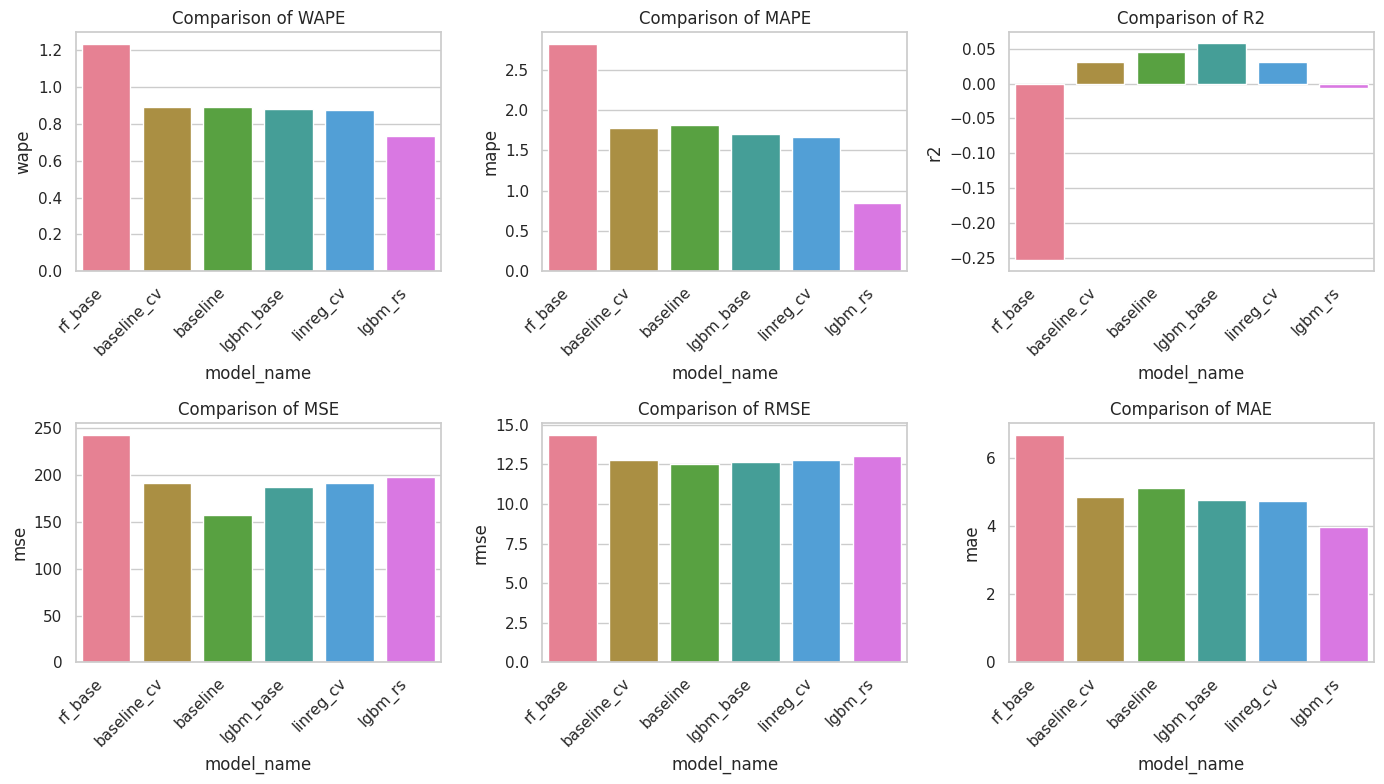

In [34]:
DatasetExplorer.models_comparison(connection=connection,
                                  postgres_credentials=postgres_credentials,
                                  experiment_name=EXPERIMENT_NAME,
                                  assets_dir=ASSETS_DIR)

Выводы и наблюдения:

- модель градиентного бустинга, обученная на дополненном наборе данных с гиперпараметрами,
  <br>подобранными при помощи `Randomized Search` показала лучший на текущий момент результат: `wape = 0.733`;
- отдельно отмечу, что процесс подбора гиперпараметров и обучения модели заняли около 4.5 часов времени.

## LightGBM with Optuna

In [57]:
%%time
def objective(trial, train_features, train_labels, tscv, model):
    params = {
        'model__num_iterations': trial.suggest_int('num_iterations', 100, 1000, step=100),
        'model__learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'model__num_leaves': trial.suggest_int('num_leaves', 31, 61, step=5),
        'model__boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'model__seed': RANDOM_STATE,
        'model__num_threads': 0,
        'model__reg_lambda': trial.suggest_int('reg_lambda', 0, 6, step=2)
    }

    score = cross_val_score(model,
                            train_features,
                            train_labels,
                            cv=tscv,
                            scoring=make_scorer(DatasetExplorer.wape, greater_is_better=False)).mean()
    return score

best_params = DatasetExplorer.optuna_hparams_selection(train_features=X_train.drop(['pr_sku_id'], axis=1),
                                                       train_labels=y_train,
                                                       tscv=tscv,
                                                       objective=objective)

[I 2024-06-26 18:45:02,057] A new study created in memory with name: no-name-0a38dfb1-2a98-46c8-98db-e6e45ba486b1


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 18:46:10,011] Trial 0 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 56, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 18:47:19,325] Trial 1 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.05, 'num_leaves': 41, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 18:48:29,797] Trial 2 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.1, 'num_leaves': 31, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 18:49:36,516] Trial 3 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 18:50:51,030] Trial 4 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.1, 'num_leaves': 46, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 18:52:01,898] Trial 5 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 18:53:14,041] Trial 6 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.01, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 18:54:17,873] Trial 7 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.01, 'num_leaves': 41, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 18:55:29,854] Trial 8 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.1, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 18:56:51,488] Trial 9 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.05, 'num_leaves': 31, 'boosting_type': 'dart', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 18:58:05,803] Trial 10 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 100, 'learning_rate': 0.05, 'num_leaves': 61, 'boosting_type': 'gbdt', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 18:59:18,190] Trial 11 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.05, 'num_leaves': 41, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:00:28,690] Trial 12 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.05, 'num_leaves': 36, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:01:40,555] Trial 13 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 1000, 'learning_rate': 0.05, 'num_leaves': 61, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:02:53,855] Trial 14 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.05, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:04:05,434] Trial 15 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.01, 'num_leaves': 41, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:05:17,947] Trial 16 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:06:30,009] Trial 17 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 600, 'learning_rate': 0.05, 'num_leaves': 36, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:07:41,525] Trial 18 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 100, 'learning_rate': 0.1, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:08:54,768] Trial 19 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.01, 'num_leaves': 36, 'boosting_type': 'gbdt', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:10:08,878] Trial 20 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:11:21,332] Trial 21 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 1000, 'learning_rate': 0.1, 'num_leaves': 31, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:12:33,681] Trial 22 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 900, 'learning_rate': 0.1, 'num_leaves': 31, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:13:45,592] Trial 23 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 600, 'learning_rate': 0.1, 'num_leaves': 36, 'boosting_type': 'gbdt', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:14:57,184] Trial 24 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.1, 'num_leaves': 41, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:16:08,865] Trial 25 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.1, 'num_leaves': 51, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:17:22,980] Trial 26 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.05, 'num_leaves': 31, 'boosting_type': 'dart', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:18:36,004] Trial 27 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:19:48,462] Trial 28 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 600, 'learning_rate': 0.01, 'num_leaves': 61, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:20:34,364] Trial 29 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.1, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:21:22,645] Trial 30 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.05, 'num_leaves': 36, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:22:19,318] Trial 31 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:23:16,981] Trial 32 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.05, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:24:14,156] Trial 33 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:25:12,172] Trial 34 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:26:09,264] Trial 35 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.1, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:27:07,031] Trial 36 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 100, 'learning_rate': 0.01, 'num_leaves': 61, 'boosting_type': 'dart', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:28:04,648] Trial 37 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.05, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:29:01,921] Trial 38 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 900, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:30:00,005] Trial 39 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.1, 'num_leaves': 41, 'boosting_type': 'dart', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:30:57,378] Trial 40 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:31:59,485] Trial 41 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.1, 'num_leaves': 41, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:32:58,444] Trial 42 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.1, 'num_leaves': 46, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start tr

[I 2024-06-26 19:33:57,504] Trial 43 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 100, 'learning_rate': 0.1, 'num_leaves': 41, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:34:54,822] Trial 44 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.01, 'num_leaves': 51, 'boosting_type': 'gbdt', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:35:52,714] Trial 45 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.05, 'num_leaves': 61, 'boosting_type': 'gbdt', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:36:51,095] Trial 46 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.1, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:37:49,279] Trial 47 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 56, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:38:47,965] Trial 48 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.05, 'num_leaves': 36, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:39:48,137] Trial 49 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.1, 'num_leaves': 31, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:40:49,887] Trial 50 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 100, 'learning_rate': 0.01, 'num_leaves': 46, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:41:49,586] Trial 51 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.05, 'num_leaves': 41, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:42:49,050] Trial 52 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.05, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:43:47,899] Trial 53 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 900, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:44:46,958] Trial 54 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 1000, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start tr

[I 2024-06-26 19:45:48,201] Trial 55 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 600, 'learning_rate': 0.05, 'num_leaves': 36, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:46:47,328] Trial 56 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 900, 'learning_rate': 0.1, 'num_leaves': 41, 'boosting_type': 'gbdt', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:47:46,725] Trial 57 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.05, 'num_leaves': 51, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:48:45,469] Trial 58 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.1, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:49:44,788] Trial 59 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.05, 'num_leaves': 31, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:50:42,825] Trial 60 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:51:43,938] Trial 61 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.01, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:52:42,741] Trial 62 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.01, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:53:41,938] Trial 63 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.01, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:54:41,313] Trial 64 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 600, 'learning_rate': 0.01, 'num_leaves': 61, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:55:40,257] Trial 65 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.01, 'num_leaves': 46, 'boosting_type': 'dart', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:56:39,231] Trial 66 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.1, 'num_leaves': 56, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 19:57:38,586] Trial 67 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 41, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 19:58:38,471] Trial 68 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.05, 'num_leaves': 51, 'boosting_type': 'gbdt', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 19:59:36,451] Trial 69 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.1, 'num_leaves': 46, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:00:35,277] Trial 70 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.05, 'num_leaves': 56, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:01:33,919] Trial 71 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.01, 'num_leaves': 41, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:02:32,161] Trial 72 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.01, 'num_leaves': 36, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 20:03:30,910] Trial 73 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.01, 'num_leaves': 46, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:04:29,483] Trial 74 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 900, 'learning_rate': 0.01, 'num_leaves': 41, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:05:27,861] Trial 75 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.1, 'num_leaves': 61, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 20:06:27,154] Trial 76 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.01, 'num_leaves': 31, 'boosting_type': 'gbdt', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:07:25,105] Trial 77 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 600, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:08:21,949] Trial 78 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.1, 'num_leaves': 36, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:09:20,424] Trial 79 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.05, 'num_leaves': 41, 'boosting_type': 'dart', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 20:10:18,429] Trial 80 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 300, 'learning_rate': 0.01, 'num_leaves': 51, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 20:11:16,718] Trial 81 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.1, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:12:14,984] Trial 82 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.1, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:13:13,262] Trial 83 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 600, 'learning_rate': 0.1, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:14:11,204] Trial 84 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.1, 'num_leaves': 56, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:15:10,667] Trial 85 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.05, 'num_leaves': 61, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:16:09,217] Trial 86 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.1, 'num_leaves': 46, 'boosting_type': 'gbdt', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 20:17:07,906] Trial 87 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 900, 'learning_rate': 0.05, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:18:06,254] Trial 88 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 100, 'learning_rate': 0.1, 'num_leaves': 36, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start tr

[I 2024-06-26 20:19:05,118] Trial 89 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.05, 'num_leaves': 51, 'boosting_type': 'gbdt', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:20:03,560] Trial 90 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.05, 'num_leaves': 46, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:21:02,529] Trial 91 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.05, 'num_leaves': 31, 'boosting_type': 'dart', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:22:01,575] Trial 92 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.05, 'num_leaves': 31, 'boosting_type': 'dart', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:23:00,336] Trial 93 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 900, 'learning_rate': 0.05, 'num_leaves': 31, 'boosting_type': 'dart', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:23:58,020] Trial 94 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 600, 'learning_rate': 0.05, 'num_leaves': 36, 'boosting_type': 'dart', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:24:55,630] Trial 95 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 200, 'learning_rate': 0.01, 'num_leaves': 56, 'boosting_type': 'gbdt', 'reg_lambda': 2}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-06-26 20:25:52,220] Trial 96 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 400, 'learning_rate': 0.1, 'num_leaves': 31, 'boosting_type': 'dart', 'reg_lambda': 0}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:26:48,811] Trial 97 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 700, 'learning_rate': 0.05, 'num_leaves': 36, 'boosting_type': 'dart', 'reg_lambda': 4}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-06-26 20:27:46,352] Trial 98 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 500, 'learning_rate': 0.05, 'num_leaves': 41, 'boosting_type': 'gbdt', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set

[I 2024-06-26 20:28:44,082] Trial 99 finished with value: -0.8789240451161328 and parameters: {'num_iterations': 800, 'learning_rate': 0.1, 'num_leaves': 51, 'boosting_type': 'dart', 'reg_lambda': 6}. Best is trial 0 with value: -0.8789240451161328.


CPU times: user 4h 58min 46s, sys: 1min 10s, total: 4h 59min 57s
Wall time: 1h 43min 42s


In [67]:
best_params

{'num_iterations': 300,
 'learning_rate': 0.05,
 'num_leaves': 56,
 'boosting_type': 'gbdt',
 'reg_lambda': 4,
 'seed': 42,
 'num_threads': 0}

/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403


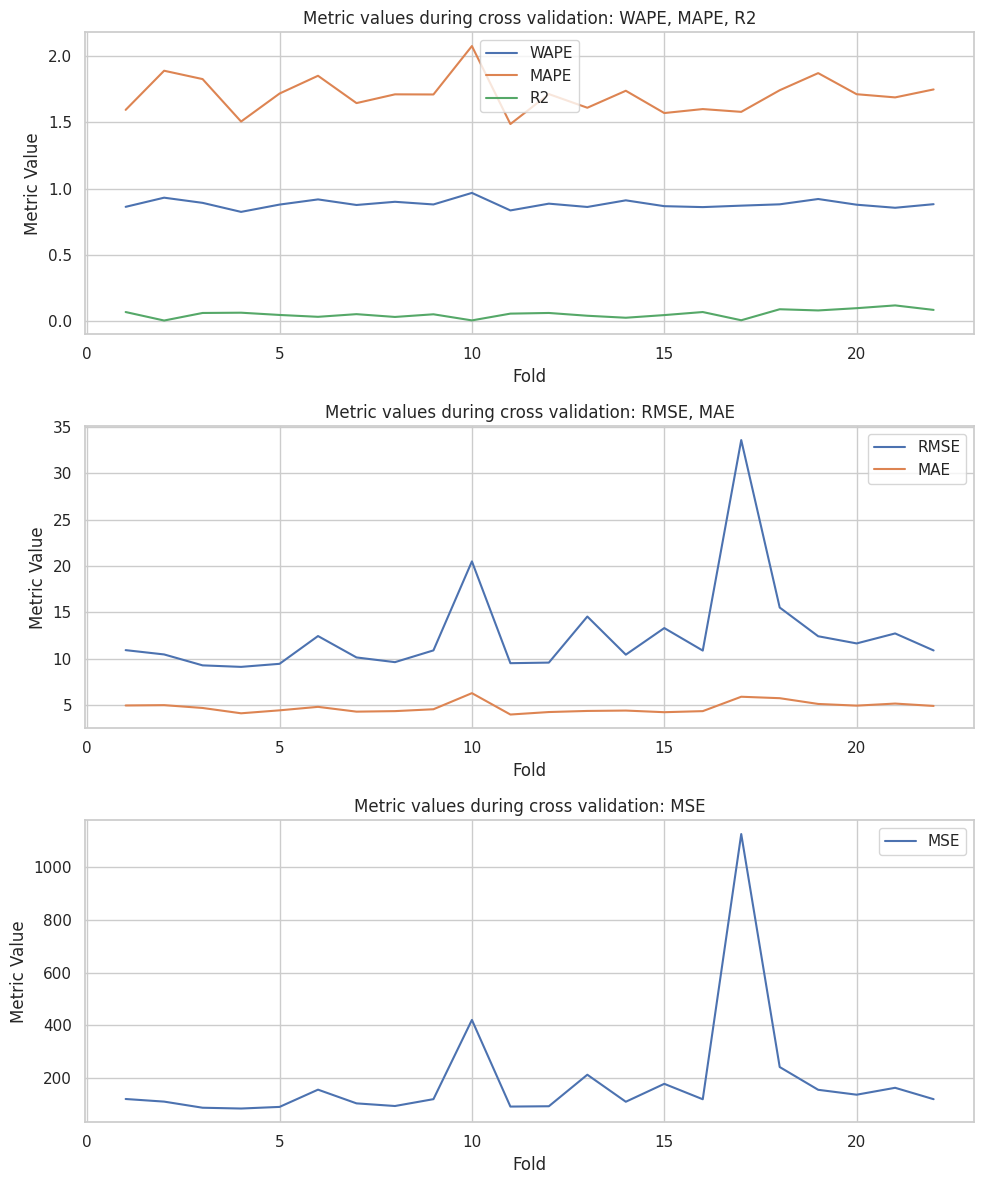

Средние значения метрик по кросс-валидации:


{'wape': 0.884,
 'mape': 1.708,
 'rmse': 12.645,
 'mae': 4.791,
 'mse': 187.243,
 'r2': 0.056}

In [68]:
gb_params = {'model__num_iterations': 300,
             'model__learning_rate': 0.05,
             'model__num_leaves': 56,
             'model__boosting_type': 'gbdt',
             'model__seed': RANDOM_STATE,
             'model__num_threads': 0,
             'model__reg_lambda': 4}
lgb_metrics, lgb_pipeline = DatasetExplorer.model_fitting(model_name='LGBM',
                                                          train_features=X_train.drop(['pr_sku_id'], axis=1),
                                                          train_labels=y_train,
                                                          assets_dir=None,
                                                          tscv=tscv,
                                                          params=gb_params,
                                                          params_selection=False)

In [70]:
metadata = {"data_used": "df_new_feat",
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn": "1.4.2",
                                 "lightgbm": "4.4.0",
                                 "optuna": "3.6.1"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
DatasetExplorer.model_logging(experiment_name=EXPERIMENT_NAME,
				   	          run_name='lgbm_optuna_registry',
					          registry_model='lgbm_optuna',
					          params=lgb_pipeline.named_steps['model'].get_params(),
					          metrics=lgb_metrics,
					          model=lgb_pipeline.named_steps['model'],
					          train_data=X_train,
                              train_label=y_train,
					          assets_dir=ASSETS_DIR,
					          metadata=metadata,
					          code_paths=code_paths,
					          tsh=TRACKING_SERVER_HOST,
					          tsp=TRACKING_SERVER_PORT)

/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'lgbm_optuna'.
2024/06/26 20:47:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: lgbm_optuna, version 1
Created versio

Models and their metrics:


experiment_name              run_name   model_name  model_version  \
0  lenta_demand_forecast         rf_0_registry      rf_base              1   
1  lenta_demand_forecast  baseline_cv_registry  baseline_cv              1   
2  lenta_demand_forecast   baseline_0_registry     baseline              1   
3  lenta_demand_forecast  lgbm_optuna_registry  lgbm_optuna              1   
4  lenta_demand_forecast       lgbm_0_registry    lgbm_base              1   
5  lenta_demand_forecast  linreg_cv_0_registry    linreg_cv              1   
6  lenta_demand_forecast      lgbm_rs_registry      lgbm_rs              1   

    wape   mape    rmse    mae      mse     r2  
0  1.234  2.821  14.377  6.670  243.111 -0.254  
1  0.893  1.778  12.801  4.832  191.194  0.031  
2  0.891  1.811  12.548  5.117  157.442  0.045  
3  0.884  1.708  12.645  4.791  187.243  0.056  
4  0.879  1.699  12.634  4.763  187.008  0.058  
5  0.874  1.664  12.801  4.727  191.186  0.031  
6  0.733  0.849  13.037  3.979  197.415 -0.007

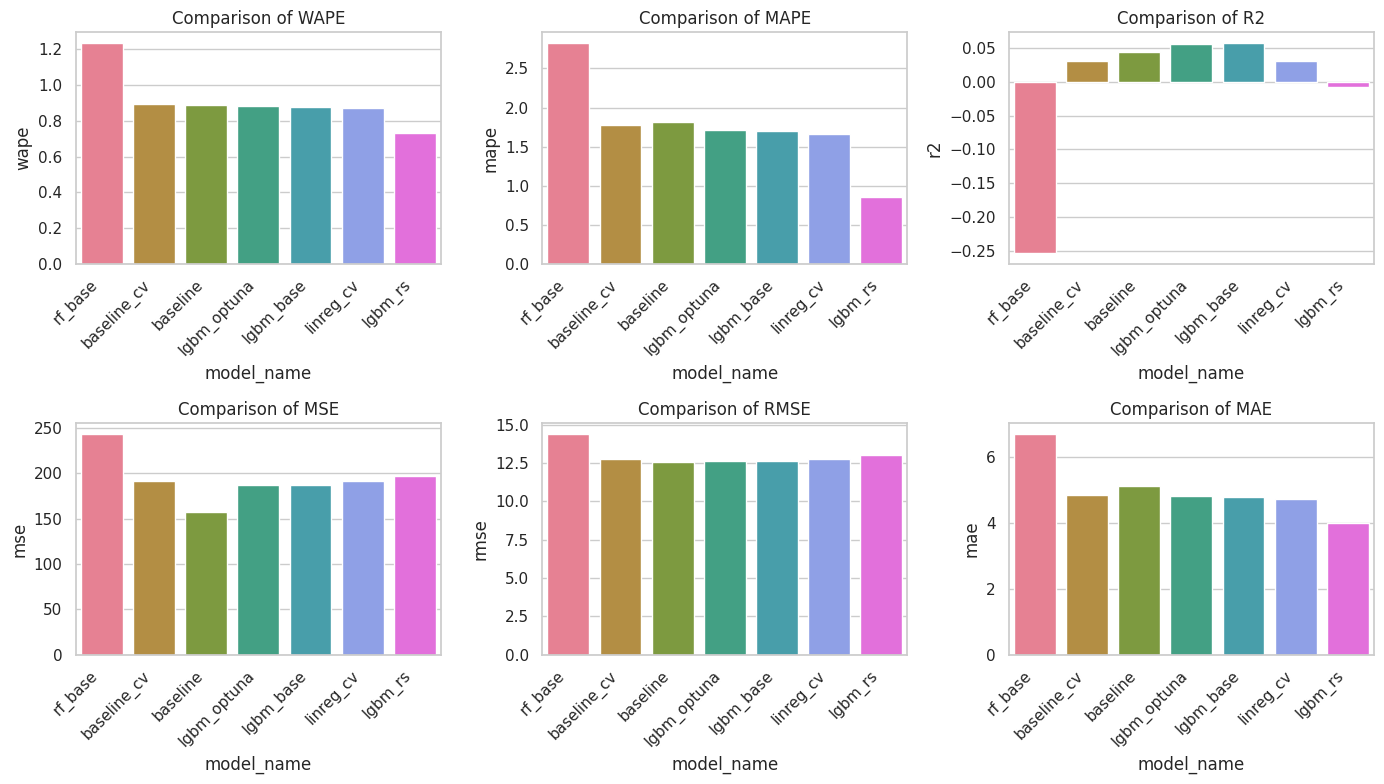

In [71]:
DatasetExplorer.models_comparison(connection=connection,
                                  postgres_credentials=postgres_credentials,
                                  experiment_name=EXPERIMENT_NAME,
                                  assets_dir=ASSETS_DIR)

Выводы и наблюдения:

- модель градиентного бустинга, обученная на дополненном наборе данных с гиперпараметрами,
  <br>подобранными при помощи Optuna показала лучший не очень хороший результат: `wape = 0.884`;
- процесс подбора гиперпараметров занял 1 час 43 минуты;
- лучшей моделью по выбранной метрике стала модель градиентного бустинга с параметрами,
  <br>подобранными при помощи `Randomized Search`.

Load/Save the best model

In [35]:
try:
    best_model = joblib.load('service/model_lgb.joblib')
except:
    joblib.dump(gb_pipeline, 'service/model_lgb.joblib')

## Testing against quality metrics on test data

Показатель wape лучшей модели на тестовой выборке 0.739


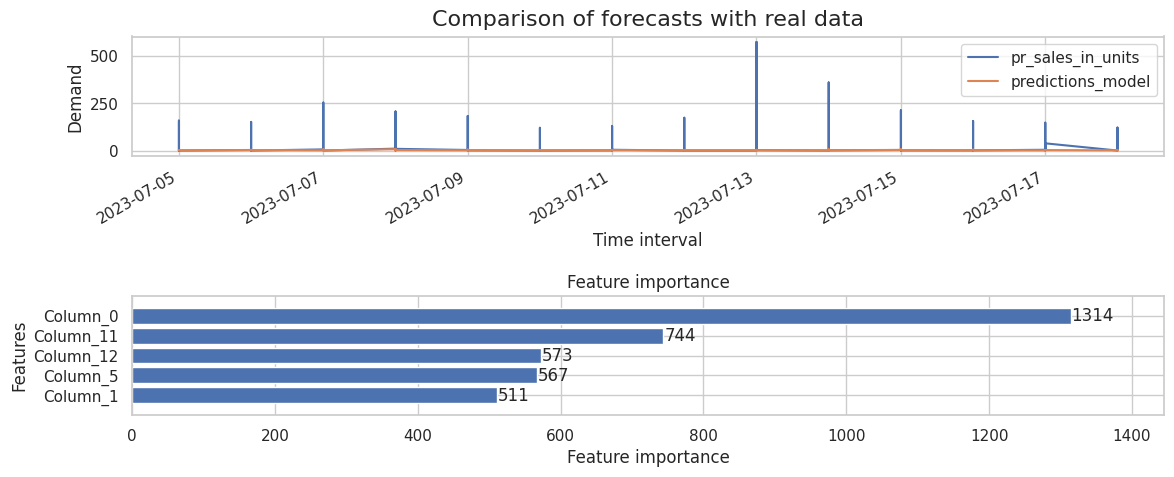

In [76]:
DatasetExplorer.test_best_model(model_name = 'LGBM',
                                model = best_model,
                                features_train = None,
                                features_test = X_test,
                                target_test = y_test,
                                assets_dir = ASSETS_DIR)

In [77]:
print(f"""Наиболее важными признаками модель определила: {X_train.columns[0],
    X_train.columns[11], X_train.columns[12], X_train.columns[5], X_train.columns[1]}""")

Наиболее важными признаками модель определила: ('st_id', 'day', 'day_of_year', 'pr_uom_id', 'pr_sku_id')


## Get forecasts for the next two weeks

In [125]:
# открытие файла, установка даты индексом
sales_submission = pd.read_csv('data/sales_submission.csv', parse_dates=['date'])

# соединение sales_submission с исходными данными
sales_with_sub = (
    pd.concat(
        [sales_df_train[['st_id', 'pr_sku_id', 'date', 'pr_sales_type_id', 'pr_sales_in_units']],
         sales_submission[['st_id', 'pr_sku_id', 'date']]], ignore_index=True, sort=False).fillna(0)
)

# добавление информации о выходных и о продуктах
sales_sub = (
    sales_with_sub
    .merge(holiday_df[['date', 'holiday']], on='date', how='left')
    .merge(products_df[['pr_sku_id', 'pr_group_id', 'pr_uom_id']], on='pr_sku_id', how='left')
)
sales_sub['pr_sales_type_id'] = 0

# добавление новых признаков
ss_new_feat = DatasetExplorer.feature_engineering(dataset=sales_sub,
                                                  target='pr_sales_in_units',
                                                  date_column='date',
                                                  group_columns=['st_id', 'pr_sku_id', 'pr_sales_type_id'],
                                                  window_size=14)

# получение дополненного датафрейма sales_submission
sales_sub_full = ss_new_feat[ss_new_feat.index >= sales_submission['date'].min()]
print('Общая информация по датафрейму:')
sales_sub_full.info()

Верхние строки набора данных:


st_id  \
date                                           
2022-08-01  6364d3f0f495b6ab9dcf8d3b5c6e0b01   
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
2022-08-01  1aa057313c28fa4a40c5bc084b11d276   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   

                                   pr_sku_id  pr_sales_type_id  \
date                                                             
2022-08-01  ee441af33a59b66a2026b029a24f269a                 0   
2022-08-01  79122a5063b8a1261b8b1f03509ef957                 0   
2022-08-01  23f70c32de93a01ccf59f9138a5baa3d                 0   
2022-08-01  62d4af457ba2540ce0898a211c0cd17a                 0   
2022-08-01  7a5ebc8af2689363da125308abe00d7f                 0   

            pr_sales_in_units  holiday                       pr_group_id  \
date                                                                       
2022-08-01                5.0        0  6512bd43d9caa6e02c990b0a82652dca   
2022-08-01                1.0        0  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01                1.0        0  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01                3.0        0  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01                1.0        0  c74d97b01eae257e44aa9d5bade97baf   

            pr_uom_id  rolling_mean_14d_lag3  rolling_mean_14d_lag7  \
date                                                                  
2022-08-01          1                    3.0                    7.0   
2022-08-01          1                    3.0                    2.0   
2022-08-01          1                    0.0                    1.0   
2022-08-01         17                    5.0                    3.0   
2022-08-01         17                    1.0                    3.0   

            rolling_mean_14d_lag11  rolling_mean_14d_lag14  month  day  \
date                                                                     
2022-08-01                     1.0                     1.0      8    1   
2022-08-01                     2.0                     2.0      8    1   
2022-08-01                     1.0                    11.0      8    1   
2022-08-01                     1.0                     1.0      8    1   
2022-08-01                     7.0                     2.0      8    1   

            day_of_year  day_of_week  quarter  is_month_start  is_month_end  
date                                                                         
2022-08-01          213            0        3               1             0  
2022-08-01          213            0        3               1             0  
2022-08-01          213            0        3               1             0  
2022-08-01          213            0        3               1             0  
2022-08-01          213            0        3               1             0

Общая информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43694 entries, 2023-07-19 to 2023-08-01
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   st_id                   43694 non-null  object 
 1   pr_sku_id               43694 non-null  object 
 2   pr_sales_type_id        43694 non-null  int64  
 3   pr_sales_in_units       43694 non-null  float64
 4   holiday                 43694 non-null  int64  
 5   pr_group_id             43694 non-null  object 
 6   pr_uom_id               43694 non-null  int64  
 7   rolling_mean_14d_lag3   43694 non-null  float64
 8   rolling_mean_14d_lag7   43694 non-null  float64
 9   rolling_mean_14d_lag11  43694 non-null  float64
 10  rolling_mean_14d_lag14  43694 non-null  float64
 11  month                   43694 non-null  int32  
 12  day                     43694 non-null  int32  
 13  day_of_year             43694 non-null  in

In [126]:
# обучение модели на полном наборе данных
best_model.fit(df_new_feat.drop('pr_sales_in_units', axis=1), df_new_feat['pr_sales_in_units'])

/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 815659, number of used features: 16
[LightGBM] [Info] Start training from score 5.451462


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  []),
                                                 ('cat',
                                                  CatBoostEncoder(random_state=42),
                                                  ['st_id', 'pr_group_id']),
                                                 ('numeric', StandardScaler(),
                                                  ['pr_sales_type_id',
                                                   'holiday', 'pr_uom_id',
                                                   'rolling_mean_14d_lag3',
                                                   'rolling_mean_14d_lag7',
                                                   'rolling_mean_14d_lag11',
                                                   'rolling_mean_14d_lag14',
                                                   'month', 'day',
                                                   'day_of_year', 'day_of_week',
                                                   'quarter', 'is_month_start',
                                                   'is_month_end'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LGBMRegressor(boosting_type='dart', learning_rate=0.01,
                               num_iterations=100, num_leaves=56, num_threads=0,
                               reg_lambda=0, seed=42))])

In [127]:
# Добавление предсказаний
sales_sub_full.loc[:, 'target'] = best_model.predict(sales_sub_full)
sales_sub_full.loc[:, 'target'] = round(sales_sub_full['target'], 0)

# Сброс индекса и выбор нужных колонок
sales_sub_full = sales_sub_full.reset_index()
sales_sub_full = sales_sub_full[['st_id', 'pr_sku_id', 'date', 'target']]

# Вывод первых строк
sales_sub_full.head()

/tmp/ipykernel_13194/1561337325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_sub_full.loc[:, 'target'] = best_model.predict(sales_sub_full)


st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  ad07964690e5174a996e565e06f4aaa3   
1  c81e728d9d4c2f636f067f89cc14862c  ae6b048b50f11ba5b7b8b68ea0e386cd   
2  c81e728d9d4c2f636f067f89cc14862c  ae0ea26efd73c891f6fe4f8af687c88f   
3  c81e728d9d4c2f636f067f89cc14862c  adf3f8d0e45cd2e4cfb284e1eaddc5c8   
4  c81e728d9d4c2f636f067f89cc14862c  ad8ec04e168adbc02021a7f636005b31   

        date  target  
0 2023-07-19     3.0  
1 2023-07-19     4.0  
2 2023-07-19     3.0  
3 2023-07-19     2.0  
4 2023-07-19     3.0

Сохранение предсказаний и модели

In [128]:
sales_sub_full.to_csv('sales_submission_lgb.csv', encoding='utf-8')
print('Файл сохранён')
joblib.dump(best_model, 'service/lgb_fit.model')
print('Модель сохранена')

Файл сохранён
Модель сохранена


### Заключение

- Предоставленные данные объединены в единый датафрейм, к ним присоединена информация о праздничных и выходных днях в РФ
- Проведено исследование на корреляцию в признаках, удалены зависимые признаки
- Проведено исследование на сезонность и тренд
- Добавлены синтетические признаки (лаги, даты, скользящее среднее)
- Для подготовки данных и обучения модели использован пайплайн с энкодерами
- Для прогнозирования применена применены модели различных типов:
  - Линейная регрессия;
  - Случайный лес;
  - Градиентный бустинг
- Наилучшим образом себя показала модель градиентного бустинга `LightGBM` с подобранными при помощи `Randomized Search`
  <br>оптимальными гиперпараметрами: показатель `wape` на трейне 0.733
- На тестовой выборке показатель `wape` получен 0.739
- Анализ значимости признаков показал, что наиболее важные признаки - `st_id, day, day_of_year`
- Конечная модель обучена на полном наборе данных.